In [1]:
from utils.bmds import BMDSTrainer
from utils.nn import create_mlp_layers
from utils.time import timeit
import torch
from sklearn.neighbors import BallTree
from utils.preprocessing import check_tensor
from utils.distributions import exponential_log_prob
from typing import Any, Optional, Callable
from torch import nn
from abc import abstractmethod
import numpy as np
import torchvision
from tqdm import tqdm
import numpy as np
from multiprocessing import Pool
from scipy.spatial import KDTree
import os
from utils.dist import compute_pw_im
from torch_geometric.datasets import TUDataset
from torch_geometric.utils import to_networkx
from sklearn.model_selection import KFold
from utils.trainer import ClassifierTrainer
from utils.data import NamedDataset
import pandas as pd
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
def preprocess_dataset(dataset_name):
    filename = './data/' + dataset_name.lower() + '.npz'
    if os.path.isfile(filename):
        return np.load(filename).values()
    else:
        dataset = TUDataset(root='/tmp/' + dataset_name, name=dataset_name)
        graphs = [*map(to_networkx, dataset)]
        labels = np.array([data.y.item() for data in dataset])
        # proteins, labels = utils.read_graph_dataset(dataset_name)
        # N = len(proteins)
        
        # ipsen_mikhailov_distance = netrd.distance.IpsenMikhailov()
        # dist_mat = np.zeros((N, N), dtype=float)
        # for i, j in tqdm(combinations(range(N), 2), total=N * (N - 1) // 2):
        #     dist_mat[i, j] = dist_mat[j, i] = ipsen_mikhailov_distance(proteins[i], proteins[j])
        dist_mat = compute_pw_im(graphs)
                
        np.savez(filename, labels=labels, dist_mat=dist_mat)

        return labels, dist_mat

In [3]:
eps = 1e-10
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class BaseBMDS(nn.Module):
    default_create_layers_kwargs: dict[str, Any] = {
        'activation': 'PReLU',
        'use_batch_norm': False,
        'last_layer_activation':  True,
        'last_layer_batch_norm': True,
    }

    def __init__(
        self,
        input_dim: int,
        n: int,
        *,
        n_layers: int = 2,
        hidden_dim: int = 1000,
        embedding_dim: int = 100,
        create_layers: Optional[Callable[..., list[nn.Module]]] = None,
        device: torch.device = DEVICE,
        **kwargs: Any,
    ):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n = n

        if create_layers is None:
            create_layers = create_mlp_layers
            kwargs = {**self.default_create_layers_kwargs, **kwargs}

        head_layers = create_layers(input_dim, [hidden_dim] * (n_layers - 1), hidden_dim, **kwargs)

        self.head = nn.Sequential(*head_layers).to(device)

        self.mu = nn.Parameter(torch.randn(hidden_dim, embedding_dim, device=device) / hidden_dim)
        self.sigma = nn.Parameter(torch.randn(hidden_dim, embedding_dim, device=device) / hidden_dim)

    def forward(self, inp):
        head = self.head(inp)
        return head @ self.mu, (head.pow(2) @ self.sigma.pow(2)).pow(0.5)
    
    def loss(self, batch):
        idx1, idx2, true_dist_sqr = batch.values()

        x = self.head(self.get_inp(idx1)) - self.head(self.get_inp(idx2))

        mu = x @ self.mu
        sigma = (x.pow(2) @ self.sigma.pow(2)).pow(0.5)
        
        dist_sqr = (mu + torch.randn_like(sigma) * sigma).pow(2).mean(1)
        
        log_prob = exponential_log_prob(true_dist_sqr, dist_sqr).mean()
        reg = (torch.log(self.mu.pow(2).mean(0) + self.sigma.pow(2).mean(0) + eps).sum() * self.hidden_dim - torch.log(self.sigma.pow(2) + eps).sum()) / self.n / 2
        
        return {'loss': -log_prob + reg, 'log_prob': log_prob, 'reg': reg, **self.get_metrics()}
        
    @abstractmethod
    def get_inp(self, idx):
        raise NotImplementedError

    def get_metrics(self):
        snfs = sorted((self.mu / self.sigma).pow(2).mean(0))[::-1]
        scales = sorted(self.mu.pow(2).mean(0) + self.sigma.pow(2).mean(0))[::-1]
        return {**{f"snf # {i + 1}": snfs[i] for i in [4, *range(13, 17), *range(24, 34, 2)]}}


class DefaultBMDS(BaseBMDS):
    def __init__(
            self,
            dist,
            *args,
            device: torch.device = DEVICE,
            **kwargs: Any,
    ):
        super().__init__(*args, **kwargs)
        
        self.dist_sqr = check_tensor(dist, device=device).pow(2)
        
    def get_inp(self, idx):
        return self.dist_sqr[idx]

class NeighborsBMDS(BaseBMDS):
    def __init__(
            self,
            dist,
            neighbors,
            batch_size,
            *args,
            device: torch.device = DEVICE,
            **kwargs: Any,
    ):
        super().__init__(*args, **kwargs)
        
        self.dist_sqr = check_tensor(dist, device=device).pow(2)
        self.neighbors = check_tensor(neighbors, device=device)
        
        self.batch_size = batch_size
        self.obj_idx = torch.arange(batch_size, device=device).repeat(dist.shape[1], 1).T.reshape(-1)

    def get_inp(self, idx):
        neighbors_idx = self.neighbors[idx].reshape(-1)
        neighbors_dist_sqr = self.dist_sqr[idx].reshape(-1)
        
        return torch.sparse_coo_tensor(
            indices=torch.stack((self.obj_idx, neighbors_idx)),
            values=neighbors_dist_sqr,
            size=(self.batch_size, self.input_dim),
        )


class RandomObjectsBMDS(BaseBMDS):
    def __init__(self, dist, *args, device: torch.device = DEVICE, **kwargs):
        super().__init__(*args, **kwargs)

        self.dist = check_tensor(dist, device=device)
    
    def get_inp(self, idx):
        return self.dist[idx]
    
    
class NeighborsDataset(torch.utils.data.Dataset):
    def __init__(self, dist, neighbors):
        super().__init__()
        
        self.object_idx = torch.arange(dist.shape[0]).repeat(dist.shape[1], 1).T.reshape(-1)
        self.neighbors_idx = check_tensor(neighbors, dtype=torch.int64).reshape(-1)
        self.dist_sqr = (check_tensor(dist).reshape(-1) / dist.max()).pow(2)
        
    def __len__(self):
        return self.dist_sqr.shape[0]
    
    def __getitem__(self, idx):
        return {'idx1': self.object_idx[idx], 'idx2': self.neighbors_idx[idx], 'dist_sqr': self.dist_sqr[idx]}
    
    
def create_generator(dataset: torch.utils.data.Dataset, batch_size: int = 128, shuffle: bool = True, drop_last: bool = True, **kwargs):
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, **kwargs)
    while True:
        yield from loader

/home/coder/project/utils/preprocessing.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(t, dtype=dtype, **kwargs)
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: antonii-belyshev. Use `wandb login --relogin` to force relogin


100%|██████████| 20000/20000 [18:49<00:00, 17.71it/s]


log_prob/train,▇▅▇▇▄▆▇▅▇▅▆▅█▆████▆█▆█▇█▇▆▆▇█▇▁▅██▅▅█▅▄▆
loss/train,▃▄▂▃▅▃▂▄▂▄▃▄▁▃▁▁▁▁▃▁▃▁▂▁▂▃▃▂▁▂█▄▁▁▄▄▁▄▅▃
reg/train,█▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 14/train,▄▂▃▃▃▃▁▁▂▂▂▂▂▂▂▃▄▂▂▃▃▃▆▅▅▄▅▄▄▇▆▅▄▅▆▄▅▃▆█
snf # 15/train,█▅▅▅▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 16/train,█▅▅▅▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 17/train,█▅▅▄▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 5/train,▁▁▂▂▁▂▂▂▃▃▃▃▄▃█▆▃▃▃▃▃▂▃▄▃▃▃▄▅▃▃▆▂▂▅▅▃▃▃▆
log_prob/train,-0.04082
loss/train,0.04183
reg/train,0.00101


number components: tensor(14, device='cuda:0')


100%|██████████| 5000/5000 [00:41<00:00, 121.88it/s]


loss/train,█▇▆▆▅▄▃▄▃▂▂▂▂▂▂▁▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
loss/train,0.03392


train accuracy: 0.993006993006993
eval_accuracy: 0.9732142857142857


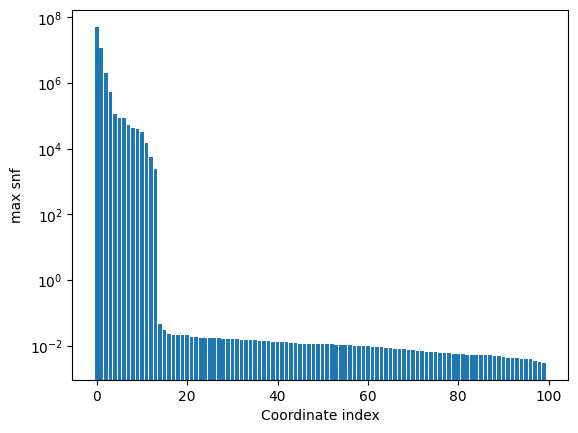

/home/coder/project/utils/preprocessing.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(t, dtype=dtype, **kwargs)


100%|██████████| 20000/20000 [18:30<00:00, 18.01it/s]


log_prob/train,▃▄▁▇▂▅▅█▄▆▇▆▃▂▆▄▂▇▇▄▆▇▅▅▅█▄▅▄▄▅▁▇▂█▅█▅▆█
loss/train,▇▅█▂▆▄▄▁▅▂▂▂▆▇▂▅▇▂▂▅▂▂▃▃▃▁▅▄▅▅▄▇▂▇▁▄▁▃▃▁
reg/train,█▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 14/train,▄▃▃▃▄▃▃▃▂▁▁▁▁▄▃▄▃▄▅▅▅▃▆▃▄▇▄█▄▂▄▆▄▆▄▆▆▇▄▅
snf # 15/train,▄▃▃▄▄▃▃▂▁▁▁▁▁▂▁▂▂▃▃▅▃▂▃▂▃▇▃▄▄▃▂▄▃▂▃▆▅█▄▂
snf # 16/train,█▆▆▆▆▄▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 17/train,█▆▆▅▆▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 5/train,▁▁▁▂▁▂▂▃▄▃▃█▄▂▄▃▂▄▃▃▄▄▃▂▄▂▃▃▂▂▆▅▃▄▃▄▄▃▃▃
log_prob/train,-0.06288
loss/train,0.06402
reg/train,0.00114


number components: tensor(15, device='cuda:0')


100%|██████████| 5000/5000 [00:39<00:00, 125.83it/s]


loss/train,█▇▆▅▅▅▃▄▃▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,0.03199


train accuracy: 0.99000999000999
eval_accuracy: 0.9642857142857143


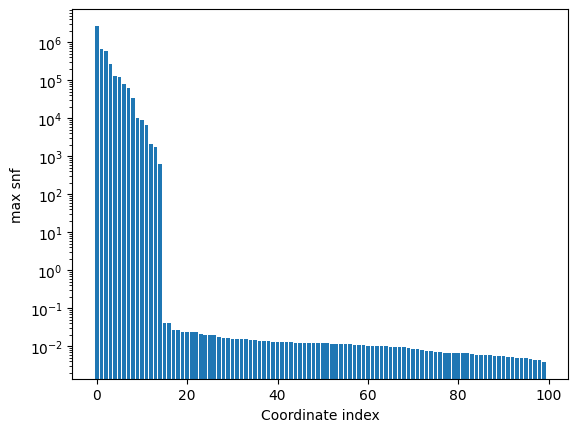

/home/coder/project/utils/preprocessing.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(t, dtype=dtype, **kwargs)


100%|██████████| 20000/20000 [18:11<00:00, 18.33it/s]


log_prob/train,▄▁▃▅▂█▇▅▅▆▆▄▅▅▄▆█▆▇▃▆▄▃▅▇▆▇▂▇▇▄▅█▃▇▇▇▃▅▆
loss/train,▆█▆▄▇▁▂▃▃▂▃▄▄▄▄▃▁▃▂▅▃▄▅▄▂▃▂▆▂▂▅▄▁▅▂▂▂▅▃▃
reg/train,█▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 14/train,▃▂▂▂▂▂▂▄▁▂▄▃▃▅▄▅█▄▄▆▆▃▆▆▄▆▅█▄▃▄▆▄▄▆▅▄▃▄█
snf # 15/train,▄▂▂▂▂▂▃▃▁▃▂▁▃▁▃▅█▄▃▅▆▄▃▄▃▃▅▆▄▃▄▃▃▂▇▄▄▃▃▆
snf # 16/train,█▅▅▄▄▅▅▃▂▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 17/train,█▅▄▄▄▄▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 5/train,▁▁▁▂▂▂▃▅▄▆▅▄▄▄▇▂█▄▆▄▄▄▅▇▃▇▃▆▄▄▄▇▅▄▇▄▇▄█▇
log_prob/train,-0.10435
loss/train,0.10533
reg/train,0.00098


number components: tensor(16, device='cuda:0')


100%|██████████| 5000/5000 [00:42<00:00, 116.96it/s]


loss/train,█▇▆▆▅▄▄▃▂▃▃▂▂▂▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,0.01387


train accuracy: 0.994005994005994
eval_accuracy: 0.9642857142857143


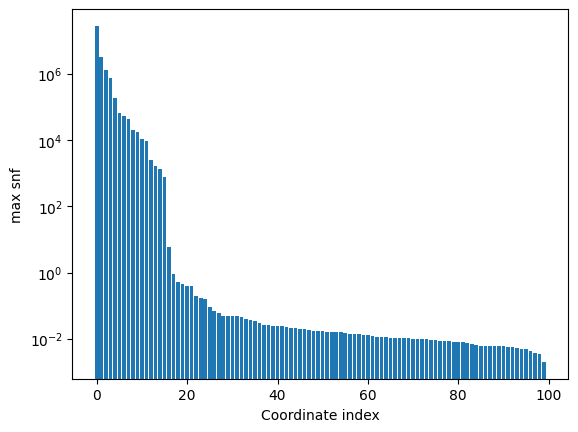

/home/coder/project/utils/preprocessing.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(t, dtype=dtype, **kwargs)


100%|██████████| 20000/20000 [19:20<00:00, 17.24it/s] 


log_prob/train,▃▄▆▁▆▅█▆▇▆▅▅▅▅█▇█▅▆▅▇▇▃▇▆▅▄▅██▅▇▇▇▇▇▇█▇▅
loss/train,▇▅▄█▃▄▁▃▂▃▄▄▄▄▁▂▁▄▃▄▂▂▆▂▃▄▅▄▁▁▄▂▂▂▂▂▂▁▂▄
reg/train,█▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 14/train,▄▃▃▃▃▃▂▂▁▁▁▂▂▂▃▄▄▃▃▄▄▄▅▃▄▅▅▄▅▅▅▅▆█▅▅▅▅▃▆
snf # 15/train,▅▄▄▄▃▃▂▁▁▁▁▁▁▁▂▄▅▄▄▄▄▄▇▂▄▃▆▄▆▆▄▃▇█▃▅▆▄▄▆
snf # 16/train,█▆▇▆▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 17/train,█▆▇▆▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 5/train,▁▁▁▃▂▂▄▆▄▅▅▂▄▄▄▄▃▅▄█▆▆▄▆▅▆▅▇▇▅▄▆▇▃▄▅▅▅▆▅
log_prob/train,-0.08017
loss/train,0.08121
reg/train,0.00104


number components: tensor(15, device='cuda:0')


100%|██████████| 5000/5000 [00:40<00:00, 124.06it/s]


loss/train,█▇▆▅▄▃▄▃▂▂▂▂▂▂▂▁▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
loss/train,0.04208


train accuracy: 0.9960079840319361
eval_accuracy: 0.972972972972973


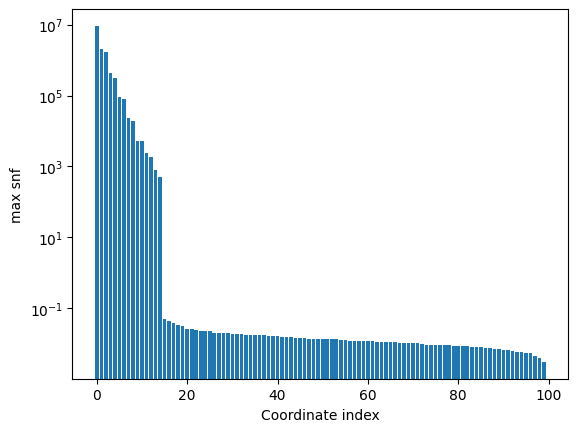

/home/coder/project/utils/preprocessing.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(t, dtype=dtype, **kwargs)


100%|██████████| 20000/20000 [18:53<00:00, 17.65it/s]


log_prob/train,▂▆▃▅█▂▅▄▆▅▆▅▅▁▅▄▄▇▆▄▄▄▇▅▅▅▄▇▅▅▄█▇▃█▇▇▅▅▅
loss/train,█▃▇▅▁▇▄▅▃▄▃▄▄█▄▅▅▂▃▅▅▅▂▄▄▄▅▂▄▄▅▁▂▆▁▂▂▄▄▄
reg/train,█▆▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 14/train,▃▂▃▂▂▁▁▁▂▂▂▆▄▄▆█▄▄▄▇▄▄█▃▆▄▅▃▆▅▃▃▃▄▇▄▄▄▅▆
snf # 15/train,▃▃▃▂▂▂▁▁▂▂▂▆▄▄▅▂▄▅▄▃▄▅█▃▆▃▄▃▆▆▄▃▃▃▃▄▃▃▃▅
snf # 16/train,█▆▆▅▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 17/train,█▆▆▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 5/train,▁▁▁▂▂▃▄▄▄▃▅▃█▄▄▆▃▄▄▆▅▄▇▄▅▄▃▅▆▆▄▅▅▄▄▄▇▆▃▄
log_prob/train,-0.10262
loss/train,0.10364
reg/train,0.00102


number components: tensor(15, device='cuda:0')


100%|██████████| 5000/5000 [00:40<00:00, 124.02it/s]


loss/train,█▇▇▅▅▄▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▂▂▂▁▁▁▁▁▁▁▁
loss/train,0.03581


train accuracy: 0.9960079840319361
eval_accuracy: 0.963963963963964


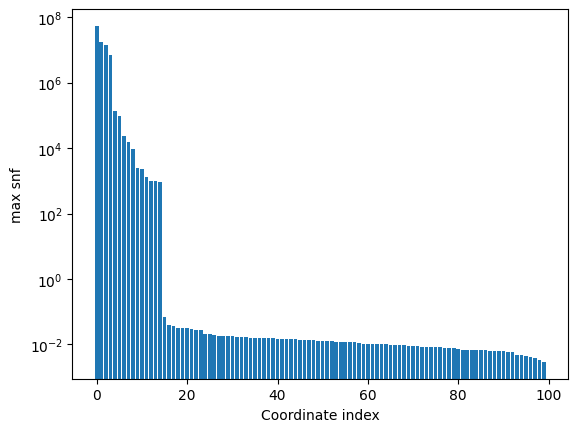

/home/coder/project/utils/preprocessing.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(t, dtype=dtype, **kwargs)


100%|██████████| 20000/20000 [18:31<00:00, 17.99it/s] 


log_prob/train,▂▇▄▄▆▄▄▆▁██▃▆▆▃▄█▆█▃▆▅▂█▁▃▅▆▃▅▄█▅▆▄▄▆▁▃▅
loss/train,█▃▆▅▃▅▄▃▇▁▁▆▃▃▅▄▁▃▁▆▃▄▆▁▇▆▄▃▅▄▄▁▄▃▄▄▂▇▆▄
reg/train,█▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 14/train,▂▂▂▂▂▁▁▂▄▂▂▃▃▅▄▃▆▄▃▅▄▃▄▃▃▅▃▃▂█▄▂▃▅▃▃▄▃▄▅
snf # 15/train,▂▂▂▁▃▁▁▂▃▂▂▃▃▃▂▂▄▄▃▂▄▄▄▃▃▂▃▂▃█▃▂▃▄▂▃▃▃▄▃
snf # 16/train,▃▂▂▂▂▁▂▂▁▂▂▃▃▂▂▂▄▄▃▂▃▄▅▂▁▃▂▂▂█▃▂▃▃▂▃▂▃▃▃
snf # 17/train,█▇▇▅▄▄▃▂▂▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 5/train,▁▁▁▃▂▂▃▃▃▂▄▄▃▅▅▃▃▄▃▃█▅▄▃▅▄▇▆▄▄▅▃▄▅▂▄▅▄▄█
log_prob/train,-0.0378
loss/train,0.03888
reg/train,0.00108


number components: tensor(16, device='cuda:0')


100%|██████████| 5000/5000 [00:43<00:00, 114.38it/s]


loss/train,█▇▇▅▅▃▃▃▂▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,0.02194


train accuracy: 0.9970059880239521
eval_accuracy: 0.963963963963964


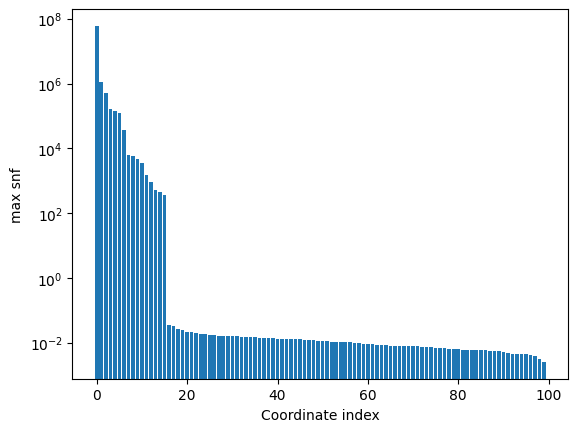

/home/coder/project/utils/preprocessing.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(t, dtype=dtype, **kwargs)


100%|██████████| 20000/20000 [20:52<00:00, 15.96it/s] 


log_prob/train,▄▆▅▅█▆▄▇▇▇▇▇▆▆▇▇▃▆▄█▆▄▄▇▆▁▅▆▆█▆▃█▆▆▂▆▆▇▇
loss/train,▆▄▅▄▂▃▅▂▂▂▂▂▃▃▂▂▆▃▅▁▃▅▅▂▃█▄▃▃▁▃▆▁▃▃▇▃▃▂▂
reg/train,█▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 14/train,▂▁▁▂▂▃▃▄▅▃▃▃▆▃▄▄▃▄▃▅▅▅▂▃▆▄▄█▅▅▄▃▃▅▃▅▄▄▃▄
snf # 15/train,▃▁▁▂▂▂▃▂▄▄▃▃▇▂▄▃▂▄▃▄▅▃▂▃▆▃▄█▅▃▁▃▃▄▃▄▄▄▄▄
snf # 16/train,▃▁▁▂▂▁▃▂▃▃▃▃▅▂▃▃▂▁▂▃▄▃▂▃▃▂▃█▅▃▂▃▁▄▂▃▂▃▃▄
snf # 17/train,▇▅▄▄▅▄▃▄▃▄▅▆█▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 5/train,▁▁▁▁▂▂▃▃▆▃▄▄▆▅▄▃▄▃▃▃▄▄▂▃▃▄▃▃▄▃▃▃▄▄▃▃▂▃▄█
log_prob/train,-0.10274
loss/train,0.10383
reg/train,0.00109


number components: tensor(16, device='cuda:0')


100%|██████████| 5000/5000 [00:43<00:00, 114.43it/s]


loss/train,██▆▆▅▄▄▃▃▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,0.00818


train accuracy: 0.999001996007984
eval_accuracy: 0.963963963963964


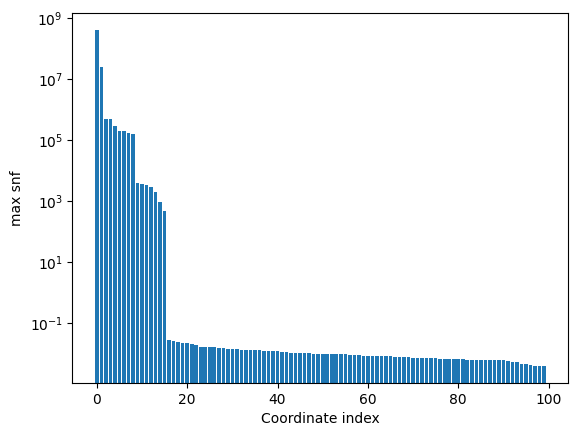

/home/coder/project/utils/preprocessing.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(t, dtype=dtype, **kwargs)


100%|██████████| 20000/20000 [19:27<00:00, 17.13it/s] 


log_prob/train,▅▆▆▇▆▇█▂▅▇▅▆▅▆▇▅▇▄█▄▆▇▇█▇▄█▅▅▅▆▆▆█▇▁▄█▅▇
loss/train,▅▃▄▂▃▂▁▇▄▂▄▃▄▃▂▄▂▅▁▅▃▂▂▁▂▅▁▄▄▄▃▃▃▁▂█▅▁▄▂
reg/train,█▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 14/train,▃▂▂▂▂▁▁▁▂▂▄▄▃▃█▇▄▃▄▄▅▅▅▄▇▃▃▆▅▃▄▄▃▆▃▅▄▃▃▅
snf # 15/train,▃▃▂▂▂▁▁▁▁▂▄▂▃▃█▆▃▃▅▂▃▆▅▅▅▄▃▄▄▄▆▄▃▇▃▆▃▃▄▅
snf # 16/train,█▆▅▄▄▃▂▂▂▃▄▅█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 17/train,█▆▅▄▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 5/train,▁▁▂▂▃▃▂▃▃▄▆▅▄▅▄▄▃▄▃▅█▄▅▄▄▃▂▅▂▃▄▅▄▆▄▃▇▆▆▃
log_prob/train,-0.03453
loss/train,0.0355
reg/train,0.00097


number components: tensor(15, device='cuda:0')


100%|██████████| 5000/5000 [00:41<00:00, 120.19it/s]


loss/train,█▇▆▆▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,0.01024


train accuracy: 1.0
eval_accuracy: 0.954954954954955


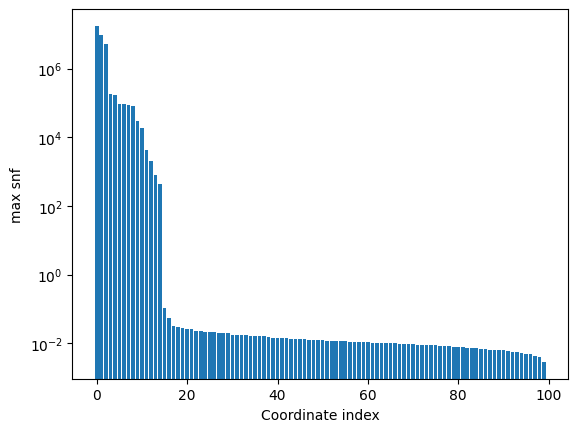

/home/coder/project/utils/preprocessing.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(t, dtype=dtype, **kwargs)


100%|██████████| 20000/20000 [20:51<00:00, 15.98it/s] 


log_prob/train,▁▇▅▅█▅▃▅▇▄▆▇▃▆▇▁██▅▆▇▃▆▅▄▄▆▄█▄▇▇▆▆▃▂▇▇▇▇
loss/train,█▃▄▄▁▃▆▄▂▄▃▂▅▃▂▇▁▁▄▃▂▅▃▄▄▄▃▄▁▅▂▂▃▃▅▆▂▂▂▂
reg/train,█▆▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 14/train,▃▂▂▁▂▁▂▃▃▄▄▄▃▆▃▇█▅▄▃█▆▄▄▇█▅█▅▇▅▅▅▃▅▆█▆▇█
snf # 15/train,▄▃▂▂▂▂▃▄▂▂▂▁▁▂▂▂▁▁▂▂▅▁▄▅▆▇▄█▆▇▅▄▆▄▅▃▆▇▅▆
snf # 16/train,█▆▄▃▄▃▃▅▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 17/train,█▅▄▃▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 5/train,▁▁▂▂▂▃▃▅▃▄▃▆▄█▆▄▅▆▃█▆▅▆▅▃▆▆█▄▆▃▃▇▄▄▇▅▅▄▅
log_prob/train,-0.06008
loss/train,0.06112
reg/train,0.00104


number components: tensor(15, device='cuda:0')


100%|██████████| 5000/5000 [00:41<00:00, 120.35it/s]


loss/train,█▇▆▆▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,0.00959


train accuracy: 0.9970059880239521
eval_accuracy: 0.9279279279279279


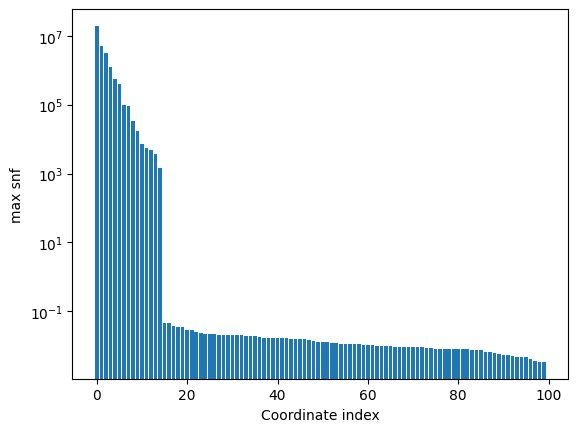

/home/coder/project/utils/preprocessing.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(t, dtype=dtype, **kwargs)


100%|██████████| 20000/20000 [18:33<00:00, 17.95it/s]


log_prob/train,▅▃▅▄▅▆▇▇▃▇▅▆▃▆▆▇▅▇▆▇▄▅▅█▅▆▁▆▇▇█▅█▆▅█▆▅█▇
loss/train,▄▇▄▆▄▃▂▂▆▂▄▃▆▃▃▂▄▂▃▂▅▄▄▁▄▃█▃▂▂▁▄▁▃▄▁▃▄▁▂
reg/train,█▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 14/train,▄▃▃▄▂▃▃▁▂▆▇▆▄▂▄▅▇▅▄▅▂▄▅▃▄▅▄▆▅▅███▆▆▄▆▅▆▆
snf # 15/train,█▆▆▇▄▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 16/train,█▆▆▄▄▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 17/train,█▅▅▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 5/train,▁▁▁▂▃▃▃▃▃▃▃▃▃▃▄▄▃▆▃▆▄▄▃▅▆▃▅▂▃▄▂█▅▂▄▄▅▃▄▇
log_prob/train,-0.0588
loss/train,0.05979
reg/train,0.00099


number components: tensor(14, device='cuda:0')


100%|██████████| 5000/5000 [00:43<00:00, 113.92it/s]


loss/train,█▇▆▆▅▄▄▃▃▃▂▂▂▂▂▁▂▂▂▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,0.0359


train accuracy: 0.9920159680638723
eval_accuracy: 0.990990990990991


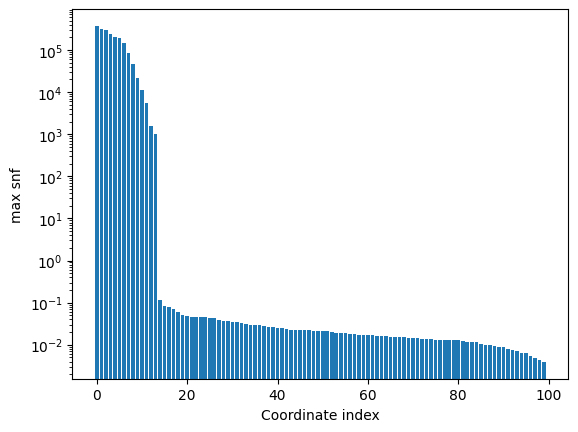

,train accuracy,evaluation accuracy
mean,0.995407,0.964052
std,0.003131,0.015906


In [4]:
dataset_name = 'PROTEINS'

labels, dist_mat = preprocess_dataset(dataset_name)

train_accs = []
eval_accs = []
k_fold = KFold(n_splits=10, shuffle=True, random_state=42)
for i, (idx_train, idx_eval) in enumerate(k_fold.split(torch.arange(len(dist_mat)))):
    labels_train, labels_eval = labels[idx_train], labels[idx_eval]
    dist_mat_train, dist_mat_eval = dist_mat[idx_train[:, None], idx_train], dist_mat[idx_eval[:, None], idx_train]

    dataset = NeighborsDataset(dist_mat_train, torch.arange(len(dist_mat_train)).repeat(len(dist_mat_train), 1))
    bmds = DefaultBMDS(dist_mat_train, len(dist_mat_train), len(dataset), hidden_dim=200)
    bmds_trainer = BMDSTrainer(bmds, lr=2e-2)

    bmds_trainer.train(create_generator(dataset, batch_size=1000), project_name=dataset_name + ' bmds', experiment_name='fold' + str(i), total_iters=20000)

    snf_mask = ((bmds.mu / bmds.sigma).pow(2) > 20).any(0)
    print('number components:', snf_mask.sum())
    embedding_train = bmds(check_tensor(dist_mat_train, device=DEVICE).pow(2))[0][:, snf_mask].detach().cpu()
    embedding_eval = bmds(check_tensor(dist_mat_eval, device=DEVICE).pow(2))[0][:, snf_mask].detach().cpu()

    clf = torch.nn.Sequential(*create_mlp_layers(embedding_train.shape[1], [100], 2))
    clf_trainer = ClassifierTrainer(clf)
    clf_trainer.train(create_generator(NamedDataset(['x', 'y'], [embedding_train, labels_train])), project_name=dataset_name + ' clf', experiment_name='fold' + str(i))

    train_acc = (clf(embedding_train.to(DEVICE)).argmax(1).detach().cpu().numpy() == labels_train).mean()
    eval_acc = (clf(embedding_eval.to(DEVICE)).argmax(1).detach().cpu().numpy() == labels_eval).mean()

    print('train accuracy:', train_acc)
    print('eval_accuracy:', eval_acc)

    train_accs.append(train_acc)
    eval_accs.append(eval_acc)

    plt.figure()
    plt.bar(range(100), sorted((bmds.mu / bmds.sigma).pow(2).max(0)[0].detach().cpu(), reverse=True))
    plt.yscale('log')
    plt.xlabel('Coordinate index')
    plt.ylabel('max snf')
    plt.show()

df = pd.DataFrame({'train accuracy': train_accs, 'evaluation accuracy': eval_accs})
pd.DataFrame({'mean': df.mean(), 'std': df.std()}).T

/home/coder/project/utils/preprocessing.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(t, dtype=dtype, **kwargs)
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: antonii-belyshev. Use `wandb login --relogin` to force relogin


100%|██████████| 20000/20000 [24:40<00:00, 13.51it/s]  


log_prob/train,▁▄▅▄▇▇▄▂▅▅▅▅████▇██████▃███▅██▅████▃████
loss/train,█▅▄▅▃▃▅▇▄▄▄▄▂▁▁▁▂▁▁▁▁▁▁▆▁▁▁▄▁▁▃▁▁▁▁▆▁▁▁▁
reg/train,▆▇████▇▆▆▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 14/train,▂▂▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▃▅▅▅▆▇▇█▆▆▆▄▇▇▆▇▇▆
snf # 15/train,▂▃▃▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▂▂▃▄▃▅▆▇▆█▇▇▇▅▇▇▆█▆▇
snf # 16/train,▂▃▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▄▄▅▆█▆▅▇▅▆▇▆▇▅▆
snf # 17/train,▂▃▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▃▄▅▇█▅▆▆▆▆▆▆█▅▆
snf # 25/train,▇███▇▇▆▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 27/train,▇███▇▇▆▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 29/train,▇███▇▆▆▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 31/train,▇███▇▆▆▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


number components: tensor(18, device='cuda:0')


100%|██████████| 5000/5000 [00:50<00:00, 98.97it/s] 


loss/train,█▆▄▄▄▃▂▄▂▂▃▃▂▁▂▂▂▂▁▁▂▂▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▃
loss/train,0.02308


train accuracy: 1.0
eval_accuracy: 0.9562043795620438


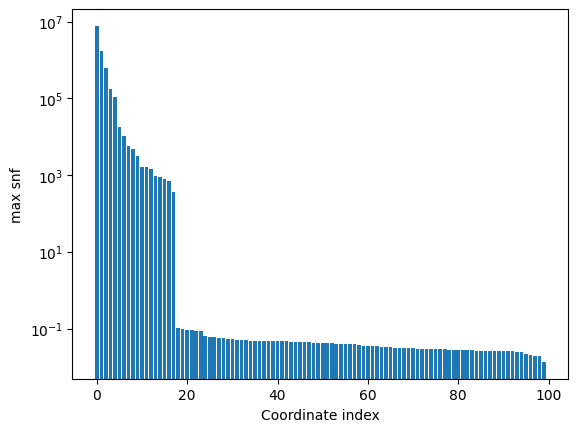

/home/coder/project/utils/preprocessing.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(t, dtype=dtype, **kwargs)


100%|██████████| 20000/20000 [23:08<00:00, 14.41it/s]  


log_prob/train,▃▁▅▆▂▇▇▅▇▅█▇▇▇██████▃▅███▅▅██▃████▆██▆█▅
loss/train,▆█▄▃▇▂▂▄▂▄▂▂▂▂▁▁▁▁▁▁▆▃▁▁▁▃▃▁▁▆▁▁▁▁▃▁▁▃▁▃
reg/train,▆▇▇███▇▇▆▅▄▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 14/train,▂▂▂▂▃▃▃▂▂▂▁▁▁▁▁▁▁▂▂▄▄▅▅▇▅▆▅▇▇▆▇▇▆█▆▆▇█▇▆
snf # 15/train,▂▂▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▂▃▆▅▇▆▇▇▇█▇▆▇▇▇▇█▇▆
snf # 16/train,▂▃▃▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▂▄▅▆▇▇▆▇▅▆▇▆▇▇█▇▆
snf # 17/train,▃▃▃▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▃▆▆▇▆▆█▅▆▆▇█▇▇▆▇
snf # 25/train,▆▇▇█▇▇▆▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 27/train,▆▇███▇▆▅▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 29/train,▆▇██▇▇▆▅▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 31/train,▆▇██▇▇▆▅▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


number components: tensor(18, device='cuda:0')


100%|██████████| 5000/5000 [00:53<00:00, 93.83it/s] 


loss/train,█▅▃▃▄▂▁▄▁▃▂▁▂▂▂▁▁▁▂▂▁▁▂▁▁▂▂▁▂▁▁▁▁▁▁▁▂▁▂▂
loss/train,0.00854


train accuracy: 1.0
eval_accuracy: 0.9416058394160584


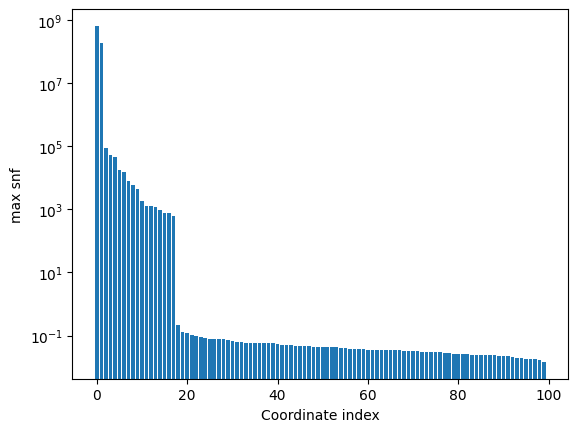

/home/coder/project/utils/preprocessing.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(t, dtype=dtype, **kwargs)


100%|██████████| 20000/20000 [23:12<00:00, 14.36it/s]  


log_prob/train,▁▆▆▆▇▆█▆███▆█████████▆██▆████▆███▅█████▇
loss/train,█▃▃▄▂▃▂▃▂▁▁▃▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▂▁▁▁▄▁▁▁▁▁▂
reg/train,▆▇████▇▇▆▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 14/train,▂▂▂▂▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▃▄▄▄▄▄▅▅▆▇▆▇▆▆▇▇█▇█▇█
snf # 15/train,▂▂▂▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▃▄▄▅▅▄▆▅▆▆▆▆▇▆▇▇█▇▇
snf # 16/train,▂▃▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▄▃▅▆▅▅▆▆▅▆▆█▇▇█▆█▇
snf # 17/train,▂▃▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▅▅▅▅▅▆▆▅▅▆▆▇█▆▇█
snf # 25/train,▇███▇▇▆▅▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 27/train,▇███▇▇▆▅▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 29/train,▇███▇▇▆▅▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 31/train,▇███▇▇▆▅▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


number components: tensor(18, device='cuda:0')


100%|██████████| 5000/5000 [00:50<00:00, 98.59it/s] 


loss/train,▆▆▃█▃▄▃▆▃▁▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▂▂▁▁
loss/train,0.011


train accuracy: 1.0
eval_accuracy: 0.9294403892944039


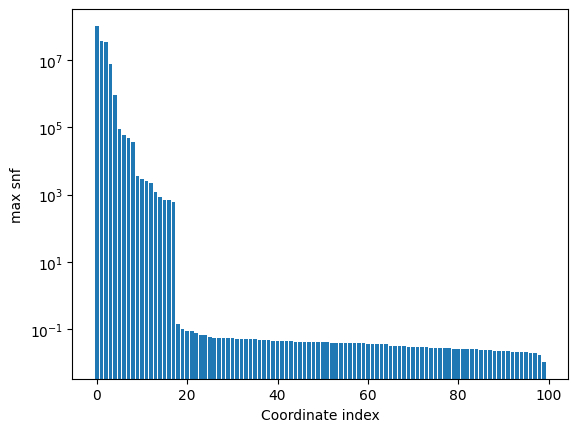

/home/coder/project/utils/preprocessing.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(t, dtype=dtype, **kwargs)


100%|██████████| 20000/20000 [23:57<00:00, 13.91it/s]  


log_prob/train,▁▄▃▇▇▆▇▇▇█▇███▆████████▆▆▆████▆██▆████▆█
loss/train,█▅▆▃▂▃▂▂▂▂▂▁▁▁▃▁▁▁▁▁▁▁▁▃▃▃▁▁▁▁▃▁▁▃▁▁▁▁▃▁
reg/train,▆▇▇███▇▆▆▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 14/train,▂▂▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▅▄▆▆▇▇██▆▇█▇▇▇█▆▇▆
snf # 15/train,▂▂▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▅▃▅▆▇▆▆▇▆▇█▇▇▆█▆▇▇
snf # 16/train,▂▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▃▃▆▇▆▆▅█▅██▆▇██▇▇▇
snf # 17/train,▂▃▃▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▂▃▄▅▅▅▆▅▇▅▆▇▅▇██▇▆▇
snf # 25/train,▆▇██▇▇▆▅▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 27/train,▆▇██▇▇▆▅▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 29/train,▆▇██▇▇▆▅▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 31/train,▆▇██▇▇▆▅▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


number components: tensor(18, device='cuda:0')


100%|██████████| 5000/5000 [00:55<00:00, 90.65it/s] 


loss/train,██▅▄▂▃▃▂▃▆▂▂▁▁▁▁▂▁▂▃▁▂▂▁▂▂▂▁▅▁▂▁▄▂▅▂▂▁▂▂
loss/train,0.00077


train accuracy: 1.0
eval_accuracy: 0.9294403892944039


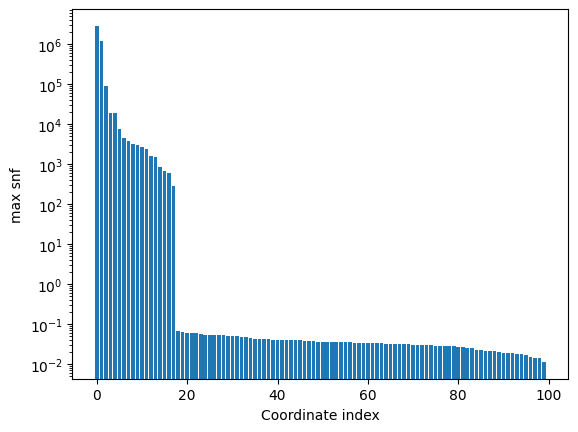

/home/coder/project/utils/preprocessing.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(t, dtype=dtype, **kwargs)


100%|██████████| 20000/20000 [23:14<00:00, 14.34it/s]  


log_prob/train,▁▄▅▆▄▄▄▄▄▇████████▅██▅▅██████▅████▅█████
loss/train,█▆▄▃▅▅▅▅▅▂▂▂▂▁▁▁▁▁▄▁▁▄▄▁▁▁▁▁▁▄▁▁▁▁▄▁▁▁▁▁
reg/train,▆▆▇███▇▇▇▆▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 14/train,▁▂▂▂▃▃▃▃▃▂▂▂▁▁▁▁▁▃▄▄▅▄▆▄▅▆▆▇▅▆▅█▇▆▇▇▆▇█▅
snf # 15/train,▂▂▂▃▃▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▂▃▄▃▄▅▇▅█▆▇▇▆▇▇▅▅
snf # 16/train,▂▂▂▃▃▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▃▅▆▅▅▆▆▆█▆▇▇▆▆
snf # 17/train,▂▂▃▃▃▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▃▅▇▅▆▅▆▆█▇▆▆▅▇
snf # 25/train,▆▆███▇▆▆▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 27/train,▆▇███▇▆▆▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 29/train,▆▇███▇▇▆▅▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 31/train,▆▇███▇▇▆▅▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


number components: tensor(18, device='cuda:0')


100%|██████████| 5000/5000 [00:51<00:00, 98.00it/s] 


loss/train,▅█▄▅▄▂▂▃▁▁▂▂▁▁▂▂▄▁▂▁▁▁▂▂▃▁▁▂▁▂▂▁▁▁▁▁▁▁▂▁
loss/train,0.02049


train accuracy: 0.9986482833198161
eval_accuracy: 0.9464720194647201


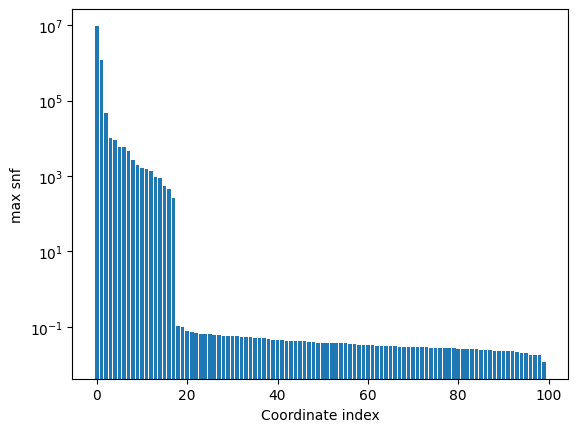

/home/coder/project/utils/preprocessing.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(t, dtype=dtype, **kwargs)


100%|██████████| 20000/20000 [25:48<00:00, 12.92it/s]  


log_prob/train,▂▁▃▄▄▅▇▇▇▇▇███████▅██▃█▆▅█████████▃█████
loss/train,▇█▆▆▅▅▂▂▂▂▂▂▂▁▁▁▁▁▄▁▁▆▁▃▄▁▁▁▁▁▁▁▁▁▆▁▁▁▁▁
reg/train,▆▆▇███▇▇▆▅▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 14/train,▂▂▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▃▅▆▅▅█▆▆▆▆▇██▆▅▆▆▇▇
snf # 15/train,▂▂▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▂▄▅▅▆▆▆▄▆▆▇█▇▅▆▆▇▇
snf # 16/train,▂▃▃▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▃▄▅▆▆▇▅▆▆▆▆█▆▇▇█▇
snf # 17/train,▃▃▃▄▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▂▃▄▄▅▄▅▆▆▅▇▆▇▅███▇
snf # 25/train,▆▇███▇▆▆▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 27/train,▆▇██▇▇▆▆▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 29/train,▆▇███▇▆▆▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 31/train,▆▇███▇▆▅▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


number components: tensor(18, device='cuda:0')


100%|██████████| 5000/5000 [00:55<00:00, 89.85it/s] 


loss/train,█▇▅▄▂▂▂▂▃▂▁▂▁▁▂▂▂▁▁▁▃▁▁▁▂▁▂▁▁▄▁▂▁▁▁▁▁▁▁▄
loss/train,0.01088


train accuracy: 1.0
eval_accuracy: 0.9464720194647201


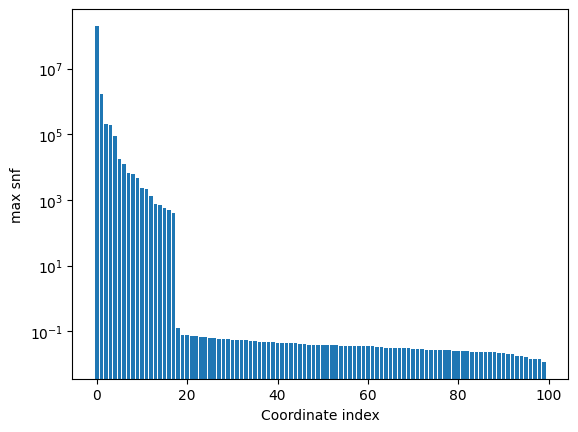

/home/coder/project/utils/preprocessing.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(t, dtype=dtype, **kwargs)


100%|██████████| 20000/20000 [23:20<00:00, 14.29it/s]  


log_prob/train,▄▃▁▅▅▇█▆█▇████▆▆▆████████████▆███▆██████
loss/train,▅▆█▄▄▂▂▃▁▂▁▁▁▁▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▃▁▁▁▁▁▁
reg/train,▆▇████▇▇▆▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 14/train,▂▂▂▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▄▄▄▅▄▆▅▇▆▇▇▇▆█▇█▇▇▆█
snf # 15/train,▂▂▂▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▂▃▃▄▄▅▅▇▆▇▇▇▇▇▇█▆▇▆█
snf # 16/train,▂▂▂▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▄▄▅▄▅▆▅▇▅▆▆▆▅▆▅█
snf # 17/train,▂▂▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▄▄▄▃▄▅▆▅▅▅▄▅█
snf # 25/train,▆████▇▆▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 27/train,▆████▇▆▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 29/train,▇████▇▆▅▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 31/train,▇████▇▆▅▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


number components: tensor(17, device='cuda:0')


100%|██████████| 5000/5000 [00:56<00:00, 89.11it/s] 


loss/train,█▅▃▃▃▂▃▃▂▂▂▁▂▂▁▁▁▁▅▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
loss/train,0.00462


train accuracy: 1.0
eval_accuracy: 0.9245742092457421


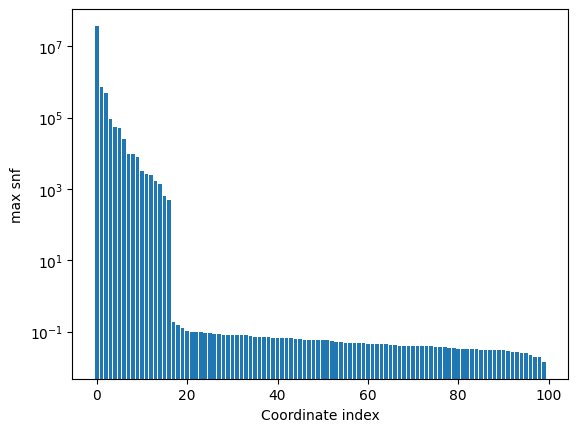

/home/coder/project/utils/preprocessing.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(t, dtype=dtype, **kwargs)


100%|██████████| 20000/20000 [23:18<00:00, 14.30it/s]  


log_prob/train,▁▁▅▆▄▇▇▇▅▇████▇██▅██████▅██████▃██▅██▅██
loss/train,██▄▃▅▃▂▂▅▂▂▂▂▁▂▁▁▄▁▁▁▁▁▁▄▁▁▁▁▁▁▆▁▁▄▁▁▃▁▁
reg/train,▆▇████▇▆▆▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 14/train,▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▃▄▅▄▄▅▅▅▅▆▅▇▆▅█▄▆▆▇▆
snf # 15/train,▂▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▂▄▃▄▅▅▅▆▆▆▇▆██▆▇▅▇▇▇▆
snf # 16/train,▃▃▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▂▂▄▄▅▄▇▅▅█▇▆█▆▇▆█▇█▇
snf # 17/train,▃▃▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▄▄▄▆▅▅▇▆▆▇▆▆▆▅▇█▇
snf # 25/train,▇▇██▇▇▆▅▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 27/train,▇███▇▇▆▅▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 29/train,▇███▇▇▆▅▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 31/train,▇███▇▇▆▅▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


number components: tensor(18, device='cuda:0')


100%|██████████| 5000/5000 [00:58<00:00, 85.03it/s] 


loss/train,██▄▃▄▄▃▃▃▃▂▁▁▁▁▁▁▁▁▁▂▂▁▁▁▃▁▁▁▃▁▂▁▄▁▁▁▁▁▁
loss/train,0.00278


train accuracy: 1.0
eval_accuracy: 0.9391727493917275


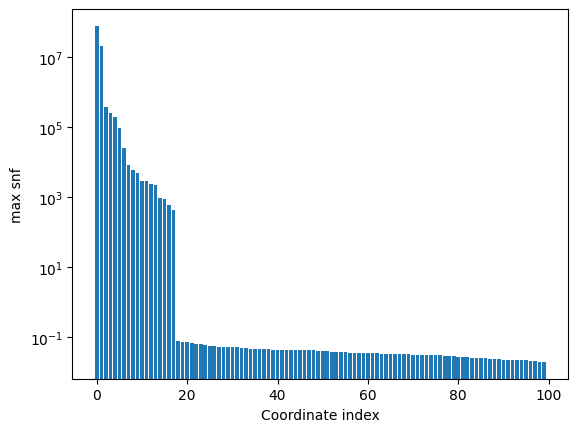

/home/coder/project/utils/preprocessing.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(t, dtype=dtype, **kwargs)


100%|██████████| 20000/20000 [23:16<00:00, 14.32it/s]  


log_prob/train,▁▄▅▆▄▄▇▇▇▇▇██▅█▅██████▅█▅▅▅▅██▅█▅█▅██▃█▅
loss/train,█▅▄▃▅▅▃▂▂▂▂▁▁▄▁▄▁▁▁▁▁▁▄▁▄▄▄▄▁▁▄▁▄▁▄▁▁▆▁▄
reg/train,▆▇▇██▇▇▆▆▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 14/train,▂▂▂▃▃▂▃▂▂▂▁▁▁▁▁▁▁▁▂▂▄▅▅▅▆▅▆▇▅▆▅▇▆▆▆▆▇█▆▇
snf # 15/train,▂▂▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▃▄▄▆▆▅▇█▅▅▆█▇▆▆▆▇▇▇█
snf # 16/train,▂▂▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▃▄▅▆▅▅▇▅▅▅▇▆▆▅▅▆▇▅█
snf # 17/train,▂▃▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▄▄▅▅▃▅▅▄▅█▇▄▅▅▄▇▆▇
snf # 25/train,▇▇██▇▆▆▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 27/train,▇▇██▇▆▆▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 29/train,▇▇███▇▆▅▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 31/train,▇▇██▇▆▆▅▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


number components: tensor(17, device='cuda:0')


100%|██████████| 5000/5000 [00:53<00:00, 93.43it/s] 


loss/train,█▆▄▃▂▂▂▂▃▁▃▁▄▁▁▁▁▁▁▂▁▁▂▁▂▃▁▁▁▂▂▁▁▁▂▁▂▁▁▁
loss/train,0.0048


train accuracy: 1.0
eval_accuracy: 0.9464720194647201


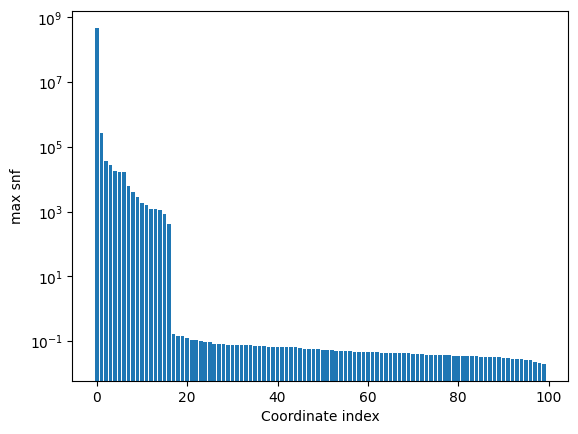

/home/coder/project/utils/preprocessing.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(t, dtype=dtype, **kwargs)


100%|██████████| 20000/20000 [24:42<00:00, 13.49it/s]  


log_prob/train,▁▅▄▇▇▇▇▇█▆██▆█▆▄████▆▄█▆█▆██▆████████▄▄▆
loss/train,█▄▅▂▂▂▂▂▂▄▂▁▃▁▃▅▁▁▁▁▃▅▁▃▁▃▁▁▃▁▁▁▁▁▁▁▁▅▅▃
reg/train,▆▇████▇▇▆▅▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 14/train,▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▃▃▄▄▄▅▅▅▅▅▅▄█▇▅▇▆█▇▆
snf # 15/train,▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▃▄▄▃▄▅▅▆▄▅▅█▅▅▆▆█▆▆
snf # 16/train,▂▂▂▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▄▅▃▅▄▅▅▅▇▆▆▅▇█▆▆
snf # 17/train,▂▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▃▄▄▆▅▅▆▆█▇▇▅▅▇▆▅
snf # 25/train,▆▇███▇▆▅▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 27/train,▆▇██▇▇▆▅▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 29/train,▇▇██▇▇▆▅▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 31/train,▇███▇▇▆▅▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


number components: tensor(17, device='cuda:0')


100%|██████████| 5000/5000 [00:56<00:00, 88.04it/s] 


loss/train,█▆▃▃▄▂▂▁▃▃▂▁▁▁▂▁▁▁▁▁▂▂▂▂▁▁▁▁▅▁▁▁▁▁▁▁▁▁▂▁
loss/train,0.01175


train accuracy: 1.0
eval_accuracy: 0.9221411192214112


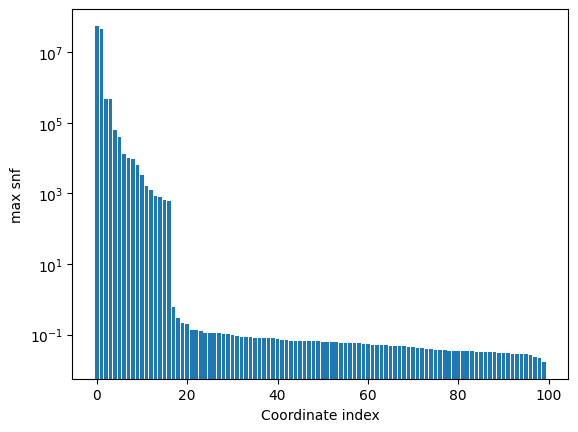

,train accuracy,evaluation accuracy
mean,0.999865,0.93820
std,0.000427,0.01125


In [4]:
dataset_name = 'NCI1'

labels, dist_mat = preprocess_dataset(dataset_name)

train_accs = []
eval_accs = []
k_fold = KFold(n_splits=10, shuffle=True, random_state=42)
for i, (idx_train, idx_eval) in enumerate(k_fold.split(torch.arange(len(dist_mat)))):
    labels_train, labels_eval = labels[idx_train], labels[idx_eval]
    dist_mat_train, dist_mat_eval = dist_mat[idx_train[:, None], idx_train], dist_mat[idx_eval[:, None], idx_train]

    dataset = NeighborsDataset(dist_mat_train, torch.arange(len(dist_mat_train)).repeat(len(dist_mat_train), 1))
    bmds = DefaultBMDS(dist_mat_train, len(dist_mat_train), len(dataset))
    bmds_trainer = BMDSTrainer(bmds, lr=1e-3)

    bmds_trainer.train(create_generator(dataset, batch_size=1000), project_name=dataset_name + ' bmds', experiment_name='fold' + str(i), total_iters=20000)

    snf_mask = ((bmds.mu / bmds.sigma).pow(2) > 100).any(0)
    print('number components:', snf_mask.sum())
    embedding_train = bmds(check_tensor(dist_mat_train, device=DEVICE).pow(2))[0][:, snf_mask].detach().cpu()
    embedding_eval = bmds(check_tensor(dist_mat_eval, device=DEVICE).pow(2))[0][:, snf_mask].detach().cpu()

    clf = torch.nn.Sequential(*create_mlp_layers(embedding_train.shape[1], [100, 100, 100], 2))
    clf_trainer = ClassifierTrainer(clf, lr=1e-2)
    clf_trainer.train(create_generator(NamedDataset(['x', 'y'], [embedding_train, labels_train])), project_name=dataset_name + ' clf', experiment_name='fold' + str(i))

    train_acc = (clf(embedding_train.to(DEVICE)).argmax(1).detach().cpu().numpy() == labels_train).mean()
    eval_acc = (clf(embedding_eval.to(DEVICE)).argmax(1).detach().cpu().numpy() == labels_eval).mean()

    print('train accuracy:', train_acc)
    print('eval_accuracy:', eval_acc)

    train_accs.append(train_acc)
    eval_accs.append(eval_acc)

    plt.figure()
    plt.bar(range(100), sorted((bmds.mu / bmds.sigma).pow(2).max(0)[0].detach().cpu(), reverse=True))
    plt.yscale('log')
    plt.xlabel('Coordinate index')
    plt.ylabel('max snf')
    plt.show()

df = pd.DataFrame({'train accuracy': train_accs, 'evaluation accuracy': eval_accs})
pd.DataFrame({'mean': df.mean(), 'std': df.std()}).T

/home/coder/project/utils/preprocessing.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(t, dtype=dtype, **kwargs)
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: antonii-belyshev. Use `wandb login --relogin` to force relogin


100%|██████████| 20000/20000 [14:41<00:00, 22.70it/s]


log_prob/train,▁▄▅▅▆▃▃▅▄▄▇▄▂▅▆▅▄▃▅▇▄▁▃▇▆▄▆█▆▃█▇▂▃▅▆▆▅▃▆
loss/train,█▅▄▅▃▆▆▄▅▅▂▅▇▄▃▄▅▆▄▂▅█▆▂▃▅▃▁▃▆▁▂▇▆▄▃▃▄▆▃
reg/train,█▇▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 14/train,█▅▃▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 15/train,█▅▃▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 16/train,█▅▃▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 17/train,█▅▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 25/train,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 27/train,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 29/train,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 31/train,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


number components: tensor(12, device='cuda:0')


100%|██████████| 5000/5000 [00:26<00:00, 186.91it/s]


loss/train,█▇▆▅▅▅▄▄▃▃▄▃▃▃▃▂▃▃▂▂▂▃▃▂▂▂▃▂▂▂▂▂▂▂▁▁▂▂▂▂
loss/train,0.20376


train accuracy: 0.9633333333333334
eval_accuracy: 0.93


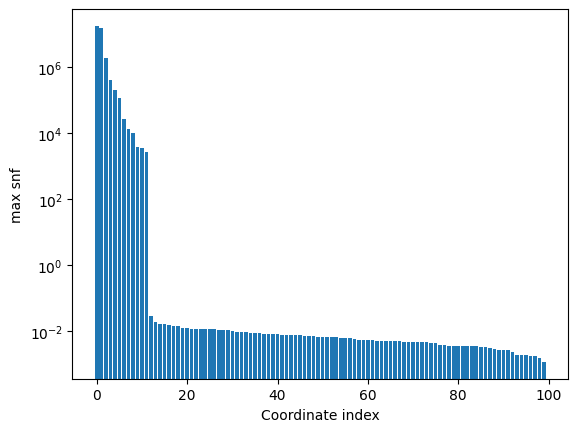

/home/coder/project/utils/preprocessing.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(t, dtype=dtype, **kwargs)


100%|██████████| 20000/20000 [14:51<00:00, 22.44it/s]


log_prob/train,█▅▇▅▂▅▅▅▄▅▇▅▇▃▅▅▄▅▃█▄▇▅▇█▇▇▇█▆▃▆▃▇▅▁▆▆▇▅
loss/train,▂▄▂▅▇▄▄▄▅▄▂▄▂▆▄▄▅▄▆▁▅▂▄▂▁▂▂▂▁▃▆▃▆▂▄█▃▃▂▄
reg/train,█▆▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 14/train,█▄▄▅▅▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 15/train,█▄▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 16/train,█▄▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 17/train,█▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 25/train,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 27/train,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 29/train,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 31/train,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


number components: tensor(12, device='cuda:0')


100%|██████████| 5000/5000 [00:25<00:00, 199.86it/s]


loss/train,██▆▆▅▆▄▄▄▃▄▄▃▃▂▂▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▂▁▁▂▂▁▂
loss/train,0.17003


train accuracy: 0.9666666666666667
eval_accuracy: 0.94


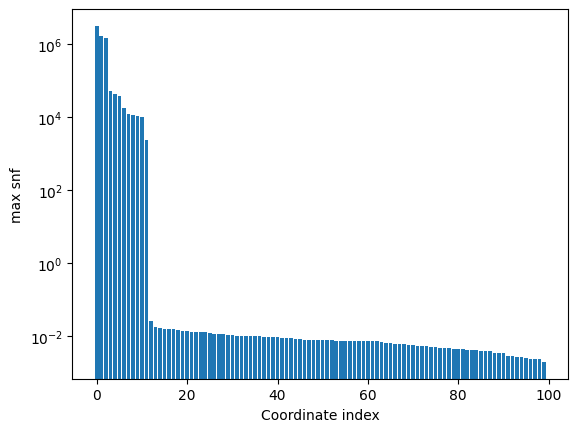

/home/coder/project/utils/preprocessing.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(t, dtype=dtype, **kwargs)


100%|██████████| 20000/20000 [14:53<00:00, 22.38it/s]


log_prob/train,▂▃▄▄▄▅▃▆▆█▆▅▆▆▇▅▄▅▃▃▆▅▅▄▅▇▃▆▄▄▅▃▄▇▆▃▆▄▁▅
loss/train,█▇▆▅▅▄▆▃▃▁▃▄▃▃▂▄▅▄▆▆▃▄▄▅▄▂▆▃▅▅▄▆▅▂▃▆▃▅█▄
reg/train,█▆▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 14/train,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 15/train,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 16/train,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 17/train,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 25/train,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 27/train,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 29/train,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 31/train,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


number components: tensor(12, device='cuda:0')


100%|██████████| 5000/5000 [00:24<00:00, 203.77it/s]


loss/train,██▆▇▆▆▅▄▃▄▄▄▃▃▄▂▃▃▃▂▂▂▂▃▂▂▂▃▂▂▂▂▁▂▁▁▂▁▁▂
loss/train,0.13324


train accuracy: 0.9366666666666666
eval_accuracy: 0.9


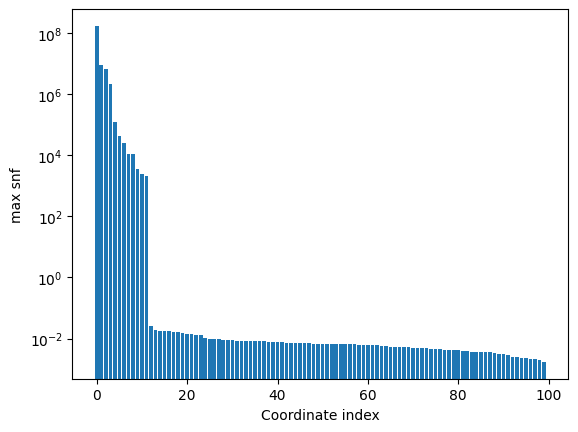

/home/coder/project/utils/preprocessing.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(t, dtype=dtype, **kwargs)


100%|██████████| 20000/20000 [14:51<00:00, 22.44it/s]


log_prob/train,▃▄▃▆▃▁█▄▆▅▂▄▆▇▃▃▆▂▃▁▆▃▇▃▅▆▆▄▇▇▃▅▃▃▂▄█▁▃▃
loss/train,▇▅▆▄▆█▁▅▃▄▇▅▃▂▅▆▃▇▆█▃▆▂▆▄▃▃▅▂▂▆▄▆▆▇▅▁█▆▅
reg/train,█▇▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 14/train,█▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 15/train,█▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 16/train,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 17/train,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 25/train,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 27/train,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 29/train,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 31/train,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


number components: tensor(12, device='cuda:0')


100%|██████████| 5000/5000 [00:24<00:00, 201.68it/s]


loss/train,██▆▅▅▅▅▅▄▅▄▄▃▃▄▃▂▃▂▂▃▂▃▂▁▂▂▂▂▁▂▂▁▁▁▂▁▂▁▂
loss/train,0.14068


train accuracy: 0.9488888888888889
eval_accuracy: 0.88


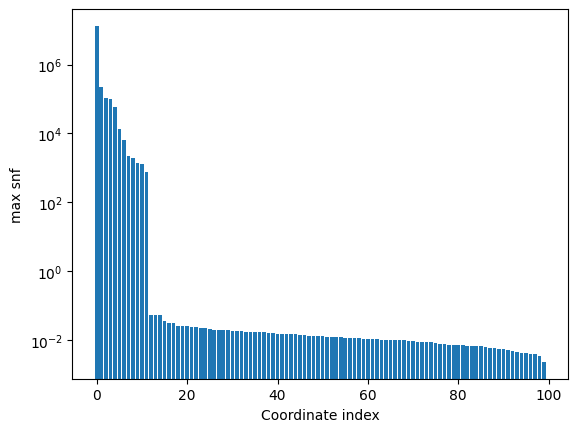

/home/coder/project/utils/preprocessing.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(t, dtype=dtype, **kwargs)


100%|██████████| 20000/20000 [14:49<00:00, 22.49it/s]


log_prob/train,▂▇▅▇▄▃▅▅▅▆▇▇▄▇▅▆▄▅▆▄▅▄▇█▇▇▁▃▄▅█▆▅▂▅▇▅▆▅█
loss/train,█▂▄▂▆▆▄▄▄▃▂▂▅▂▄▃▅▄▃▅▄▅▂▁▂▂█▆▅▄▁▃▄▇▄▂▄▃▄▁
reg/train,█▆▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 14/train,█▄▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 15/train,█▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 16/train,█▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 17/train,█▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 25/train,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 27/train,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 29/train,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 31/train,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


number components: tensor(12, device='cuda:0')


100%|██████████| 5000/5000 [00:24<00:00, 204.08it/s]


loss/train,█▇▇▅▄▅▄▄▄▄▄▃▄▃▃▃▂▂▂▂▂▃▂▂▂▂▂▂▁▁▂▁▁▂▁▁▁▁▂▁
loss/train,0.10681


train accuracy: 0.9477777777777778
eval_accuracy: 0.89


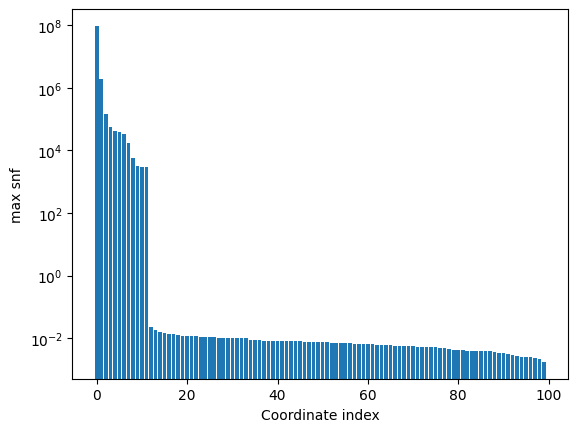

/home/coder/project/utils/preprocessing.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(t, dtype=dtype, **kwargs)


100%|██████████| 20000/20000 [14:52<00:00, 22.41it/s]


log_prob/train,▁▅▂▃▄▅▄▅▇██▅▇▄█▅▃▇▅▄▃▇▃▆█▅▇▇▅▅▆▆▅▇▆▅▃▇▆▄
loss/train,█▄▆▆▅▄▅▄▂▁▁▃▂▅▁▄▆▂▃▅▆▂▆▃▁▄▂▂▃▃▃▃▄▂▃▄▅▂▃▅
reg/train,█▆▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 14/train,█▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 15/train,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 16/train,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 17/train,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 25/train,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 27/train,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 29/train,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 31/train,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


number components: tensor(13, device='cuda:0')


100%|██████████| 5000/5000 [00:27<00:00, 180.66it/s]


loss/train,█▇▆▅▆▄▅▄▄▄▃▃▃▃▃▃▂▃▃▂▃▂▂▂▂▁▂▂▁▂▁▂▂▂▁▂▁▁▂▂
loss/train,0.1148


train accuracy: 0.9655555555555555
eval_accuracy: 0.95


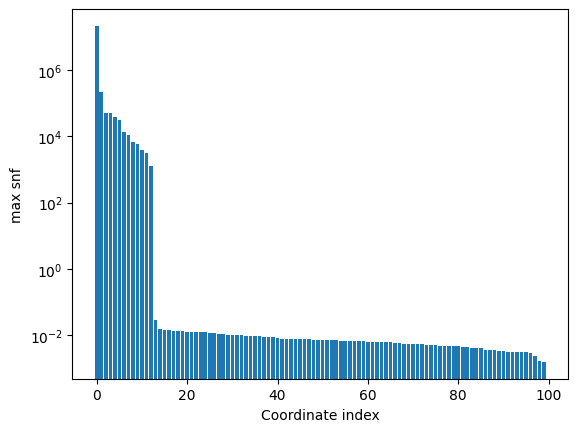

/home/coder/project/utils/preprocessing.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(t, dtype=dtype, **kwargs)


100%|██████████| 20000/20000 [14:57<00:00, 22.30it/s]


log_prob/train,▂▄▃▄▅▅▄▅▆▅█▂▃▅▅▃▆▄▃▃▆▇▄▅▁▆▆▂█▅▆▄▅▅▆▄▃▃▇▅
loss/train,▇▅▆▅▄▄▅▄▃▄▁█▆▄▄▆▃▅▆▆▃▁▅▄█▃▃▇▁▄▃▅▄▄▃▅▆▆▂▄
reg/train,█▆▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 14/train,█▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 15/train,█▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 16/train,█▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 17/train,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 25/train,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 27/train,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 29/train,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 31/train,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


number components: tensor(12, device='cuda:0')


100%|██████████| 5000/5000 [00:24<00:00, 201.06it/s]


loss/train,█▇▆▅▅▅▄▅▄▄▄▄▃▃▃▂▃▃▃▃▃▂▂▂▃▂▂▂▃▂▂▂▂▁▂▂▁▂▁▁
loss/train,0.1663


train accuracy: 0.96
eval_accuracy: 0.94


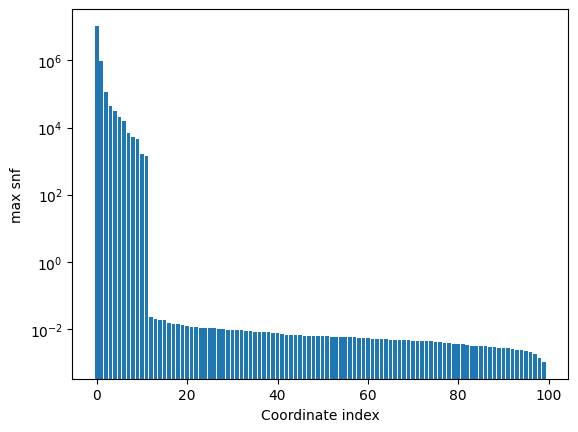

/home/coder/project/utils/preprocessing.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(t, dtype=dtype, **kwargs)


100%|██████████| 20000/20000 [14:56<00:00, 22.31it/s]


log_prob/train,▇▅▇▇▄▄▆▆▃▅▆▃▇▁▄▆▄▆▅▇▇▆▄▇█▆▆▇▆▆▆▄█▇▇▆▆▄▇▅
loss/train,▂▄▃▃▅▅▃▃▆▄▃▆▂█▅▃▅▃▄▂▂▃▅▂▁▃▃▂▃▃▃▄▁▂▂▃▃▅▂▄
reg/train,█▆▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 14/train,█▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 15/train,█▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 16/train,█▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 17/train,█▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 25/train,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 27/train,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 29/train,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 31/train,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


number components: tensor(12, device='cuda:0')


100%|██████████| 5000/5000 [00:24<00:00, 206.47it/s]


loss/train,█▇▆▆▆▆▆▄▄▃▃▃▄▃▄▃▂▂▃▂▂▂▃▃▂▂▂▂▂▁▁▁▂▁▂▂▁▁▂▁
loss/train,0.11009


train accuracy: 0.96
eval_accuracy: 0.94


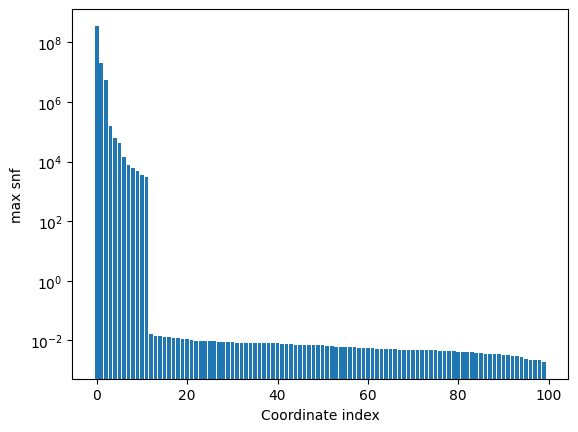

/home/coder/project/utils/preprocessing.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(t, dtype=dtype, **kwargs)


100%|██████████| 20000/20000 [15:04<00:00, 22.11it/s]


log_prob/train,▇▅██▅▆▄▅▅▅▆▇▅▁▇▄██▆▃▅▅▃▄▅▅▆▇▆▆▆▄▃▅▂▄▄▆▅▄
loss/train,▂▅▁▁▄▃▅▄▄▄▃▂▄█▂▅▁▁▃▆▄▄▆▅▄▄▃▂▃▃▃▅▅▄▇▅▅▃▄▅
reg/train,█▆▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 14/train,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 15/train,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 16/train,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 17/train,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 25/train,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 27/train,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 29/train,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 31/train,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


number components: tensor(12, device='cuda:0')


100%|██████████| 5000/5000 [00:27<00:00, 181.97it/s]


loss/train,██▇▅▅▆▄▅▄▄▄▄▃▃▃▄▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▂
loss/train,0.11683


train accuracy: 0.9622222222222222
eval_accuracy: 0.92


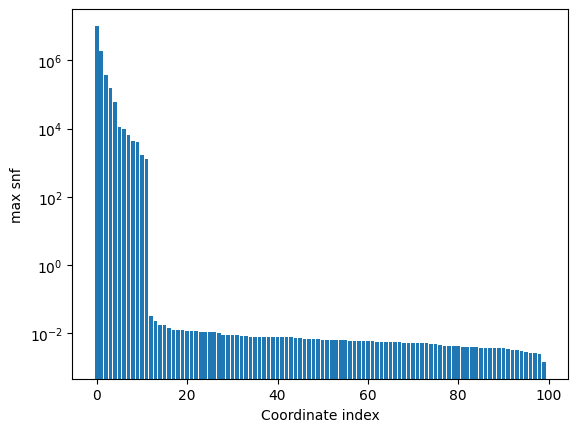

/home/coder/project/utils/preprocessing.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(t, dtype=dtype, **kwargs)


100%|██████████| 20000/20000 [14:59<00:00, 22.24it/s]


log_prob/train,▆▃▅▃▆▇▆▆▇▇▆▆▇▇▄██▆▆▁█▇▅▆▇▆▇▆▇▄█▇▄▆▄█▆▇▇▇
loss/train,▄▆▄▆▄▂▃▃▂▂▃▃▂▂▅▁▁▃▃█▁▂▄▃▂▃▂▃▂▅▁▂▅▃▅▁▃▂▂▂
reg/train,█▆▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 14/train,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 15/train,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 16/train,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 17/train,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 25/train,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 27/train,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 29/train,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 31/train,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


number components: tensor(13, device='cuda:0')


100%|██████████| 5000/5000 [00:23<00:00, 212.73it/s]


loss/train,█▆▆▆▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▃▂▁▂▃▁▂▁▁▁▁▂▁▂▁▂▁▂▁
loss/train,0.11524


train accuracy: 0.9611111111111111
eval_accuracy: 0.9


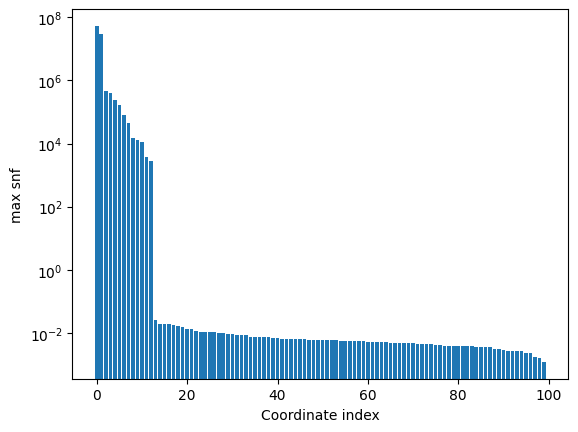

,train accuracy,evaluation accuracy
mean,0.957222,0.919000
std,0.009619,0.024698


In [4]:
dataset_name = 'IMDB-BINARY'

labels, dist_mat = preprocess_dataset(dataset_name)

train_accs = []
eval_accs = []
k_fold = KFold(n_splits=10, shuffle=True, random_state=42)
for i, (idx_train, idx_eval) in enumerate(k_fold.split(torch.arange(len(dist_mat)))):
    labels_train, labels_eval = labels[idx_train], labels[idx_eval]
    dist_mat_train, dist_mat_eval = dist_mat[idx_train[:, None], idx_train], dist_mat[idx_eval[:, None], idx_train]

    dataset = NeighborsDataset(dist_mat_train, torch.arange(len(dist_mat_train)).repeat(len(dist_mat_train), 1))
    bmds = DefaultBMDS(dist_mat_train, len(dist_mat_train), len(dataset), hidden_dim=200)
    bmds_trainer = BMDSTrainer(bmds, lr=2e-2)

    bmds_trainer.train(create_generator(dataset, batch_size=1000), project_name=dataset_name + ' bmds', experiment_name='fold' + str(i), total_iters=20000)

    snf_mask = ((bmds.mu / bmds.sigma).pow(2) > 20).any(0)
    print('number components:', snf_mask.sum())
    embedding_train = bmds(check_tensor(dist_mat_train, device=DEVICE).pow(2))[0][:, snf_mask].detach().cpu()
    embedding_eval = bmds(check_tensor(dist_mat_eval, device=DEVICE).pow(2))[0][:, snf_mask].detach().cpu()

    clf = torch.nn.Sequential(*create_mlp_layers(embedding_train.shape[1], [100], 2))
    clf_trainer = ClassifierTrainer(clf)
    clf_trainer.train(create_generator(NamedDataset(['x', 'y'], [embedding_train, labels_train])), project_name=dataset_name + ' clf', experiment_name='fold' + str(i))

    train_acc = (clf(embedding_train.to(DEVICE)).argmax(1).detach().cpu().numpy() == labels_train).mean()
    eval_acc = (clf(embedding_eval.to(DEVICE)).argmax(1).detach().cpu().numpy() == labels_eval).mean()

    print('train accuracy:', train_acc)
    print('eval_accuracy:', eval_acc)

    train_accs.append(train_acc)
    eval_accs.append(eval_acc)

    plt.figure()
    plt.bar(range(100), sorted((bmds.mu / bmds.sigma).pow(2).max(0)[0].detach().cpu(), reverse=True))
    plt.yscale('log')
    plt.xlabel('Coordinate index')
    plt.ylabel('max snf')
    plt.show()

df = pd.DataFrame({'train accuracy': train_accs, 'evaluation accuracy': eval_accs})
pd.DataFrame({'mean': df.mean(), 'std': df.std()}).T

/home/coder/project/utils/preprocessing.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(t, dtype=dtype, **kwargs)
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: antonii-belyshev. Use `wandb login --relogin` to force relogin


100%|██████████| 20000/20000 [14:21<00:00, 23.22it/s]


log_prob/train,▂▃▆▆▆▇▁▇▇▇▄█▇▅▅▇█▅▅▅▅▇███▂█▅▂██▇▇█▂▅▂▅██
loss/train,█▇▄▄▃▂▇▂▂▂▄▁▂▄▄▂▁▄▄▄▄▁▁▁▁▆▁▄▆▁▁▁▁▁▆▃▆▄▁▁
reg/train,█▇▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 14/train,█▇▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 15/train,█▆▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 16/train,█▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 17/train,█▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 25/train,█▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 27/train,█▆▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 29/train,█▆▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 31/train,█▆▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


number components: tensor(10, device='cuda:0')


100%|██████████| 5000/5000 [00:23<00:00, 212.18it/s]


loss/train,██▅▆▆▅▅▄▅▅▃▄▄▄▃▄▄▃▂▂▃▂▃▂▁▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁
loss/train,0.1445


train accuracy: 0.9198113207547169
eval_accuracy: 0.9661016949152542


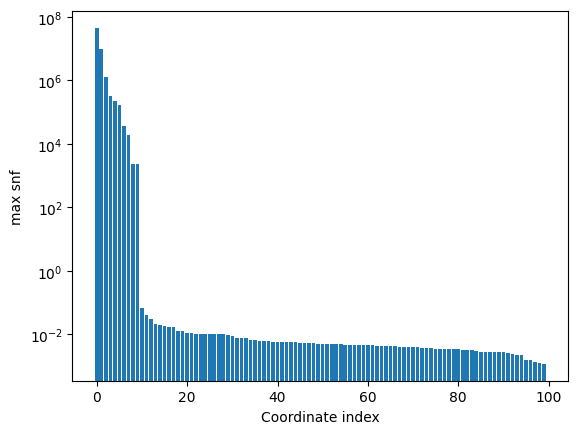

/home/coder/project/utils/preprocessing.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(t, dtype=dtype, **kwargs)


100%|██████████| 20000/20000 [14:45<00:00, 22.59it/s]


log_prob/train,▅▅▅▆▅▄▆▂▆▄▆█▆▄▆▆▆█▄█▁▆▄▁▅██▅██████▅█▆█▆█
loss/train,▅▅▄▄▄▅▃▇▄▅▃▁▃▅▃▃▃▁▅▁█▃▅█▄▁▁▄▁▁▁▁▁▁▄▁▃▁▃▁
reg/train,█▆▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 14/train,█▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 15/train,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 16/train,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 17/train,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 25/train,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 27/train,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 29/train,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 31/train,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


number components: tensor(10, device='cuda:0')


100%|██████████| 5000/5000 [00:22<00:00, 226.78it/s]


loss/train,█▆▇▆▆▆▅▅▄▄▅▃▄▄▃▃▂▃▃▂▂▂▃▃▃▂▂▂▁▂▃▂▂▃▂▁▂▂▁▃
loss/train,0.16703


train accuracy: 0.909433962264151
eval_accuracy: 0.8983050847457628


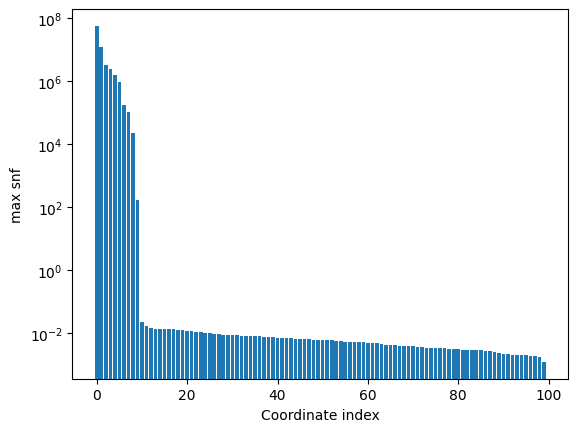

/home/coder/project/utils/preprocessing.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(t, dtype=dtype, **kwargs)


100%|██████████| 20000/20000 [14:48<00:00, 22.51it/s]


log_prob/train,▃▃▆▇▇▂▇▃▃▆▅▅▁▅██▇▆▃▁▁██▁▆▆▆██▄██▅▆▅▄█▁▆▃
loss/train,██▄▃▂▇▂▆▆▃▄▄█▄▁▁▂▃▆██▁▁█▃▃▃▁▁▅▁▁▄▃▃▅▁█▃▆
reg/train,█▆▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 14/train,█▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 15/train,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 16/train,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 17/train,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 25/train,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 27/train,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 29/train,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 31/train,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


number components: tensor(11, device='cuda:0')


100%|██████████| 5000/5000 [00:24<00:00, 201.20it/s]


loss/train,▇█▇▆▇▄▅▄▄▄▅▃▃▃▂▃▄▂▃▂▃▂▂▂▂▃▂▁▂▂▂▂▂▃▂▂▁▁▁▂
loss/train,0.09616


train accuracy: 0.9509433962264151
eval_accuracy: 0.923728813559322


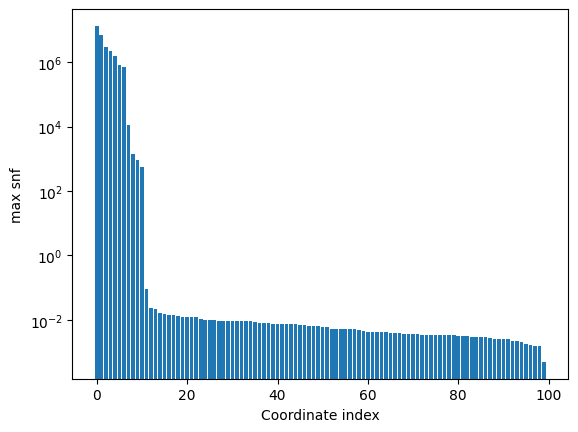

/home/coder/project/utils/preprocessing.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(t, dtype=dtype, **kwargs)


100%|██████████| 20000/20000 [14:52<00:00, 22.41it/s]


log_prob/train,▄▆▇▇▅▅▁▇▇▆▆▇▆▆▆▄▆▇▆▄▆▃▄▆█▄▆▄▄█▂█▄█▄▆▄█▆▄
loss/train,▆▄▃▃▅▄█▂▂▃▃▂▃▃▃▅▃▂▃▅▃▆▅▃▁▅▃▅▅▁▇▁▅▁▅▃▅▁▃▅
reg/train,█▆▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 14/train,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 15/train,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 16/train,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 17/train,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 25/train,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 27/train,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 29/train,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 31/train,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


number components: tensor(10, device='cuda:0')


100%|██████████| 5000/5000 [00:24<00:00, 205.20it/s]


loss/train,█▆▇▆▆▃▄▄▄▃▃▅▃▃▃▂▃▂▃▃▄▂▂▂▁▂▃▂▁▂▂▁▃▂▂▃▁▂▁▁
loss/train,0.11018


train accuracy: 0.9433962264150944
eval_accuracy: 0.9067796610169492


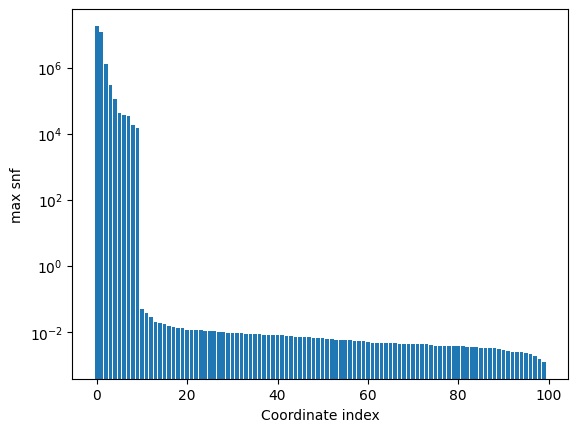

/home/coder/project/utils/preprocessing.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(t, dtype=dtype, **kwargs)


100%|██████████| 20000/20000 [14:48<00:00, 22.51it/s]


log_prob/train,▂▆▄▇▆▄██▆▆█▆▆▆▆▇▆▆▄▄▄▁▆▆▄█▄▃▄▆█▃███▆▅▆▆▅
loss/train,█▃▆▂▃▅▂▁▃▃▁▃▃▃▃▂▃▃▅▅▅█▃▃▅▁▅▆▅▃▁▆▁▁▁▃▄▃▃▅
reg/train,█▇▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 14/train,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 15/train,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 16/train,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 17/train,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 25/train,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 27/train,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 29/train,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 31/train,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


number components: tensor(11, device='cuda:0')


100%|██████████| 5000/5000 [00:23<00:00, 209.37it/s]


loss/train,█▇▇█▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▂▃▃▂▃▁▃▁▂▂▂▂▁▂▂▂▂▁▁▁▁
loss/train,0.16689


train accuracy: 0.9330188679245283
eval_accuracy: 0.8898305084745762


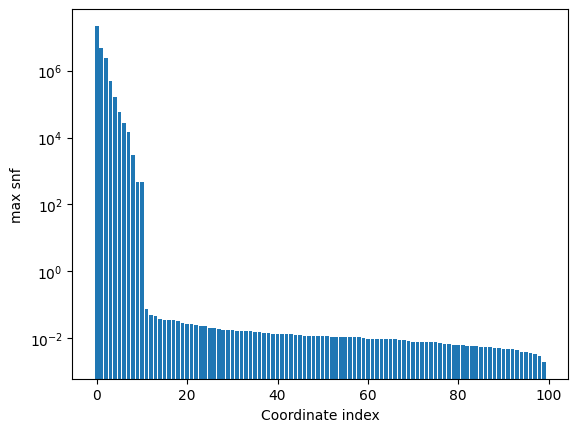

/home/coder/project/utils/preprocessing.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(t, dtype=dtype, **kwargs)


100%|██████████| 20000/20000 [14:53<00:00, 22.38it/s]


log_prob/train,▆▄▆▇▄▇▆▇▄██▆▆▅▆▇▅███▆█▁▆▆█▆▆▆███▆▆▆▅▆▆██
loss/train,▄▆▄▂▅▂▃▂▅▁▁▃▃▄▃▂▄▁▁▁▃▁█▃▃▁▃▃▃▁▁▁▃▃▃▄▃▃▁▁
reg/train,█▇▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 14/train,█▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 15/train,█▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 16/train,█▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 17/train,█▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 25/train,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 27/train,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 29/train,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 31/train,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


number components: tensor(10, device='cuda:0')


100%|██████████| 5000/5000 [00:23<00:00, 208.78it/s]


loss/train,██▇▇▇▆▅▆▆▄▄▄▃▄▄▄▃▂▂▃▂▃▂▃▃▂▂▃▂▂▂▂▂▂▂▂▂▁▁▂
loss/train,0.08696


train accuracy: 0.9424528301886792
eval_accuracy: 0.923728813559322


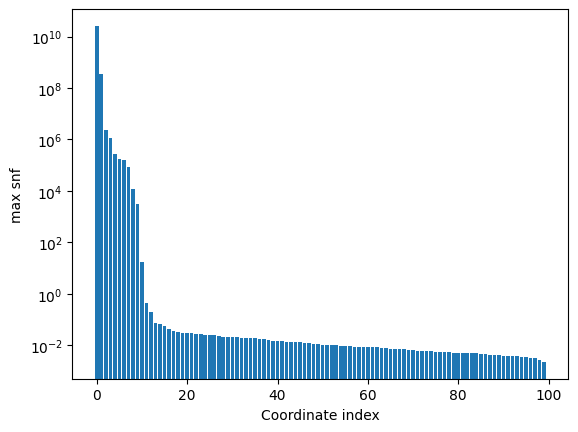

/home/coder/project/utils/preprocessing.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(t, dtype=dtype, **kwargs)


100%|██████████| 20000/20000 [14:49<00:00, 22.47it/s]


log_prob/train,▁▄▆▃▄▇▃▇▇▄▁▄▂▅▂▅▅▅▂▅▅▇██▅▇▅██▇▅▂██▅█▂▅█▅
loss/train,█▅▃▆▅▂▅▂▂▄▇▄▆▄▆▄▄▄▆▄▄▂▁▁▃▁▄▁▁▁▄▆▁▁▃▁▆▃▁▄
reg/train,█▇▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 14/train,█▆▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 15/train,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 16/train,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 17/train,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 25/train,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 27/train,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 29/train,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 31/train,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


number components: tensor(10, device='cuda:0')


100%|██████████| 5000/5000 [00:22<00:00, 219.52it/s]


loss/train,██▇▆▆▅▅▄▅▄▄▄▄▃▃▃▄▃▃▃▃▂▃▁▃▃▃▂▂▃▂▂▂▁▁▁▁▂▂▁
loss/train,0.15797


train accuracy: 0.9028301886792452
eval_accuracy: 0.8050847457627118


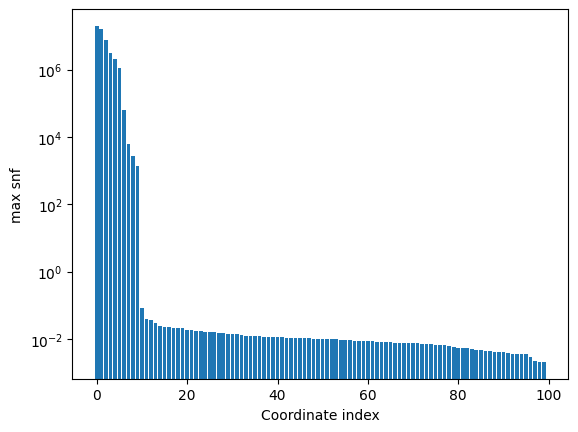

/home/coder/project/utils/preprocessing.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(t, dtype=dtype, **kwargs)


100%|██████████| 20000/20000 [14:54<00:00, 22.37it/s]


log_prob/train,▂▂▇▅▅▅▅▅▅▁█▇▆▆███████▆▆▁▁▆█▄▆▄▄██▄█▃▆█▄█
loss/train,██▃▅▄▄▄▄▄▇▁▂▃▃▁▁▁▁▁▁▁▃▃█▇▃▁▅▃▅▅▁▁▅▁▆▃▁▅▁
reg/train,█▆▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 14/train,█▆▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 15/train,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 16/train,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 17/train,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 25/train,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 27/train,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 29/train,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 31/train,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


number components: tensor(10, device='cuda:0')


100%|██████████| 5000/5000 [00:26<00:00, 188.59it/s]


loss/train,██▆▆▆▇▅▄▅▅▃▄▄▄▃▂▃▄▂▃▂▃▃▃▃▃▄▃▂▃▁▂▃▁▂▂▂▂▂▃
loss/train,0.20774


train accuracy: 0.9481132075471698
eval_accuracy: 0.940677966101695


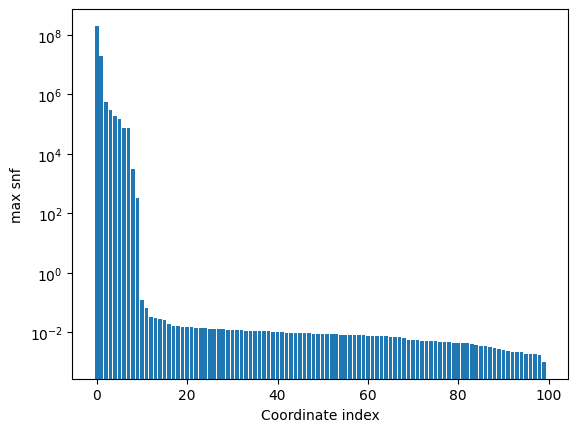

/home/coder/project/utils/preprocessing.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(t, dtype=dtype, **kwargs)


100%|██████████| 20000/20000 [14:51<00:00, 22.45it/s]


log_prob/train,▃▄▃▇▁▃▅▅▇▃▅▇▆█▅█▃▁▄█▆▆▃▆██▃▆█▄█▆▆▄▆█▄█▄▆
loss/train,▇▆▇▃█▆▄▄▂▆▄▂▃▁▄▁▅█▅▁▃▃▅▃▁▁▅▃▁▅▁▃▃▅▃▁▅▁▅▃
reg/train,█▆▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 14/train,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 15/train,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 16/train,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 17/train,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 25/train,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 27/train,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 29/train,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 31/train,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


number components: tensor(10, device='cuda:0')


100%|██████████| 5000/5000 [00:24<00:00, 201.51it/s]


loss/train,█▇▇▇▆▄▄▄▄▄▃▄▃▂▂▂▃▃▂▂▂▃▃▁▃▂▂▂▂▂▂▂▁▂▁▂▁▃▂▁
loss/train,0.15292


train accuracy: 0.9208294062205467
eval_accuracy: 0.8376068376068376


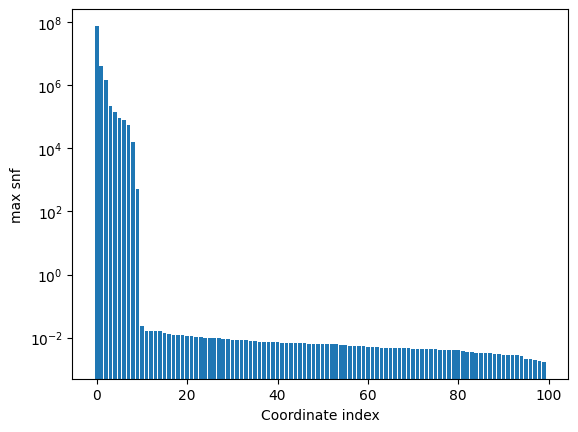

/home/coder/project/utils/preprocessing.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(t, dtype=dtype, **kwargs)


100%|██████████| 20000/20000 [14:45<00:00, 22.59it/s]


log_prob/train,▁▆▇▅▅▇▅▅▇▇▇█▅▆▅█▆▁▃▅██▃▆▃▃▅█▅▃▆▃▅██▆█▃▃▆
loss/train,█▃▃▄▄▂▄▄▂▂▂▁▃▃▃▁▃▇▅▃▁▁▅▃▅▅▄▁▃▅▃▅▃▁▁▃▁▅▅▃
reg/train,█▇▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 14/train,█▆▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 15/train,█▆▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 16/train,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 17/train,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 25/train,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 27/train,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 29/train,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
snf # 31/train,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


number components: tensor(10, device='cuda:0')


100%|██████████| 5000/5000 [00:22<00:00, 217.88it/s]


loss/train,██▆▇▆▅▅▄▄▄▄▅▃▅▄▃▃▃▂▃▂▄▂▂▃▁▂▁▂▂▂▁▂▂▂▁▁▁▂▂
loss/train,0.20358


train accuracy: 0.9076343072573044
eval_accuracy: 0.9145299145299145


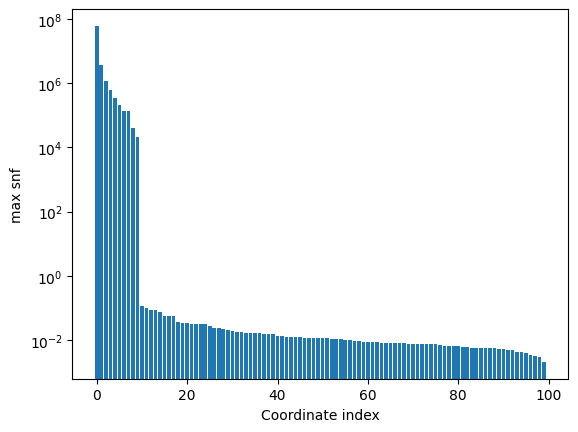

,train accuracy,evaluation accuracy
mean,0.927846,0.900637
std,0.017992,0.047623


In [4]:
dataset_name = 'DD'

labels, dist_mat = preprocess_dataset(dataset_name)

train_accs = []
eval_accs = []
k_fold = KFold(n_splits=10, shuffle=True, random_state=42)
for i, (idx_train, idx_eval) in enumerate(k_fold.split(torch.arange(len(dist_mat)))):
    labels_train, labels_eval = labels[idx_train], labels[idx_eval]
    dist_mat_train, dist_mat_eval = dist_mat[idx_train[:, None], idx_train], dist_mat[idx_eval[:, None], idx_train]

    dataset = NeighborsDataset(dist_mat_train, torch.arange(len(dist_mat_train)).repeat(len(dist_mat_train), 1))
    bmds = DefaultBMDS(dist_mat_train, len(dist_mat_train), len(dataset), hidden_dim=200)
    bmds_trainer = BMDSTrainer(bmds, lr=2e-2)

    bmds_trainer.train(create_generator(dataset, batch_size=1000), project_name=dataset_name + ' bmds', experiment_name='fold' + str(i), total_iters=20000)

    snf_mask = ((bmds.mu / bmds.sigma).pow(2) > 20).any(0)
    print('number components:', snf_mask.sum())
    embedding_train = bmds(check_tensor(dist_mat_train, device=DEVICE).pow(2))[0][:, snf_mask].detach().cpu()
    embedding_eval = bmds(check_tensor(dist_mat_eval, device=DEVICE).pow(2))[0][:, snf_mask].detach().cpu()

    clf = torch.nn.Sequential(*create_mlp_layers(embedding_train.shape[1], [100], 2))
    clf_trainer = ClassifierTrainer(clf)
    clf_trainer.train(create_generator(NamedDataset(['x', 'y'], [embedding_train, labels_train])), project_name=dataset_name + ' clf', experiment_name='fold' + str(i))

    train_acc = (clf(embedding_train.to(DEVICE)).argmax(1).detach().cpu().numpy() == labels_train).mean()
    eval_acc = (clf(embedding_eval.to(DEVICE)).argmax(1).detach().cpu().numpy() == labels_eval).mean()

    print('train accuracy:', train_acc)
    print('eval_accuracy:', eval_acc)

    train_accs.append(train_acc)
    eval_accs.append(eval_acc)

    plt.figure()
    plt.bar(range(100), sorted((bmds.mu / bmds.sigma).pow(2).max(0)[0].detach().cpu(), reverse=True))
    plt.yscale('log')
    plt.xlabel('Coordinate index')
    plt.ylabel('max snf')
    plt.show()

df = pd.DataFrame({'train accuracy': train_accs, 'evaluation accuracy': eval_accs})
pd.DataFrame({'mean': df.mean(), 'std': df.std()}).T